In [2]:
import pandas as pd
from io import StringIO
import os
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union, Set, Any
from enum import Enum
import pickle
import pandas as pd
import statsmodels.api as sm
import numpy as np
import logging
import unicodedata

from nst_scraper import nst_on_ice_scraper, nst_team_on_ice_scraper
from db_utils.nhl_db_utils import update_player_db, check_last_update, append_player_ids, get_player_full_name
from team_utils import get_most_recent_game_id, get_fullname_by_tricode
from game_utils import get_game_boxscore, display_boxscore
from pbp_utils import get_matchup_games
from db_utils.prop_odds_db_utils import get_player_shots_ou_odds

from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
np.set_printoptions(legacy='1.25')

c:\Users\H-100\Desktop\python\accurateshothelper\.venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# player_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', rate='y')
# player_stats_df.head()

In [4]:
# goalie_stats_df = nst_on_ice_scraper(fromseason=20242025, thruseason=20242025, startdate='', enddate='', pos='g', rate='y', stdoi='g')
# goalie_stats_df.head()

In [5]:
class Position(Enum):
    C = 'C'
    L = 'L'
    R = 'R'
    D = 'D'
    G = 'G'
    
    @property
    def category(self) -> str:
        if self in {Position.C, Position.L, Position.R}:
            return 'F'
        elif self == Position.D:
            return 'D'
        elif self == Position.G:
            return 'G'
    
    def __str__(self) -> str:
        return self.value

In [6]:
@dataclass
class Player:
    name: str
    team: str
    position: Position
    player_id: Optional[int] = None

    def __str__(self) -> str:
        """
        Returns a string representation of the player.
        """
        return f"{self.name} ({self.position}) - {self.team}"

    def to_dict(self) -> Dict[str, Optional[str]]:
        """
        Converts the Player instance into a dictionary.
        
        Returns:
            Dict[str, Optional[str]]: A dictionary representation of the player.
        """
        return {
            'player_id': self.player_id,
            'name': self.name,
            'team': self.team,
            'position': self.position.value
        }

In [7]:
@dataclass
class Lineup:
    name: str
    forwards: List[Optional[Player]] = field(default_factory=lambda: [None] * 12)
    defense: List[Optional[Player]] = field(default_factory=lambda: [None] * 6)
    goalies: List[Optional[Player]] = field(default_factory=lambda: [None] * 2)
    
    ALLOWED_FORWARD_CATEGORIES = {'F'}
    ALLOWED_DEFENSE_CATEGORY = 'D'
    ALLOWED_GOALIE_CATEGORY = 'G'
    
    def __post_init__(self):
        self.validate_lineup_size()
    
    def validate_lineup_size(self):
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if total_players > 20:
            raise ValueError(f"Total number of players ({total_players}) exceeds the hard limit of 20.")
    
    def add_player(
        self,
        category: str,
        player: Player,
        slot: int,
        allowed_categories: Union[str, Set[str]],
        max_slots: int
    ):
        """
        Adds a player to the specified category and slot after validating their position category.
        Ensures that the total number of players does not exceed 20.
        """
        if isinstance(allowed_categories, str):
            allowed_categories = {allowed_categories}
        elif isinstance(allowed_categories, set):
            allowed_categories = allowed_categories
        else:
            raise TypeError("allowed_categories must be a string or a set of strings.")
        
        if player.position.category not in allowed_categories:
            raise ValueError(
                f"Cannot add player '{player.name}' with position '{player.position.value}' "
                f"to {category}. Allowed categories: {', '.join(allowed_categories)}."
            )
        
        if not 0 <= slot < max_slots:
            raise IndexError(f"{category.capitalize()} slot must be between 0 and {max_slots - 1}.")
        
        current_category = getattr(self, category)
        if current_category[slot]:
            existing_player = current_category[slot].name
            print(f"Warning: Slot {slot + 1} in {category} is already occupied by '{existing_player}'. Overwriting.")
        
        # Check total players before adding
        total_players = sum(player is not None for player in self.forwards + self.defense + self.goalies)
        if current_category[slot] is None and total_players >= 20:
            raise ValueError("Cannot add more players. The lineup has reached the hard limit of 20 players.")
        
        current_category[slot] = player
        setattr(self, category, current_category)
        print(f"Added player '{player.name}' to {category.capitalize()} slot {slot + 1}.")
    
    def add_forward(self, player: Player, slot: int):
        self.add_player(
            category='forwards',
            player=player,
            slot=slot,
            allowed_categories=self.ALLOWED_FORWARD_CATEGORIES,
            max_slots=len(self.forwards)
        )
    
    def add_defense(self, player: Player, slot: int):
        self.add_player(
            category='defense',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_DEFENSE_CATEGORY},
            max_slots=len(self.defense)
        )
    
    def set_goalie(self, player: Player, slot: int):
        self.add_player(
            category='goalies',
            player=player,
            slot=slot,
            allowed_categories={self.ALLOWED_GOALIE_CATEGORY},
            max_slots=len(self.goalies)
        )
    
    def adjust_slots(self, category: str, delta: int):
        """
        Adjusts the number of slots in the specified category by delta.
        Allows ±1 adjustment only.
        
        Args:
            category (str): The category to adjust ('forwards' or 'defense').
            delta (int): The change in number of slots (+1 or -1).
        """
        if category not in {'forwards', 'defense'}:
            raise ValueError("Can only adjust 'forwards' or 'defense' categories.")
        if delta not in {-1, 1}:
            raise ValueError("Delta must be either +1 or -1.")
        
        current_slots = getattr(self, category)
        new_slot_count = len(current_slots) + delta
        
        if category == 'forwards':
            if not (11 <= new_slot_count <= 13):
                raise ValueError("Number of forwards can only vary by ±1 from the default of 12.")
        elif category == 'defense':
            if not (5 <= new_slot_count <= 7):
                raise ValueError("Number of defensemen can only vary by ±1 from the default of 6.")
        
        if delta == 1:
            current_slots.append(None)
        elif delta == -1:
            removed_player = current_slots.pop()
            if removed_player:
                print(f"Removed player '{removed_player.name}' from {category}.")
        
        setattr(self, category, current_slots)
        print(f"Adjusted {category} slots to {len(getattr(self, category))}.")
        self.validate_lineup_size()
    
    def display_lineup(self):
        """
        Prints the current lineup in a structured format.
        """
        print(f"Lineup: {self.name}\n")
        
        for category, title in [('forwards', 'Forwards'), ('defense', 'Defense'), ('goalies', 'Goalies')]:
            print(f"{title}:")
            for idx, player in enumerate(getattr(self, category), start=1):
                player_info = str(player) if player else 'Empty'
                print(f"  Slot {idx}: {player_info}")
            print()
    
    def to_dataframe(self) -> pd.DataFrame:
        """
        Converts the lineup into a pandas DataFrame.
        Conditionally includes player attributes if they are present.
        """
        data = []
        for category, pos in [('forwards', 'f'), ('defense', 'd'), ('goalies', 'g')]:
            for idx, player in enumerate(getattr(self, category), start=1):
                player_dict = {
                    'Position': f"{pos}{idx}",
                    'Player': player.name if player else 'Empty'
                }
                # Conditionally add 'player_id' if it exists
                if player and player.player_id is not None:
                    player_dict['Player ID'] = player.player_id
                data.append(player_dict)
        
        df = pd.DataFrame(data)
        
        # Optionally, remove columns where all values are NaN
        df.dropna(axis=1, how='all', inplace=True)
        
        return df
    
    def to_transposed_dataframe(self) -> pd.DataFrame:
        """
        Transposes the lineup DataFrame so that each column represents a position-slot combination
        and the row contains the corresponding player names.
        Conditionally includes additional player attributes if they are present.
        """
        df = self.to_dataframe()
        
        # Initialize dictionaries to hold player names and optional IDs
        player_data = {}
        id_data = {}
        
        for _, row in df.iterrows():
            pos = row['Position']
            player_name = row['Player']
            player_data[pos] = player_name
            
            # Handle 'Player ID' if it exists
            if 'Player ID' in row and pd.notna(row['Player ID']):
                id_data[f"{pos}_ID"] = row['Player ID']
        
        # Combine player names and IDs into a single dictionary
        transposed_data = {**player_data, **id_data}
        
        # Create the transposed DataFrame with a single row
        transposed_df = pd.DataFrame([transposed_data])
        
        return transposed_df

In [8]:
today_datetime= datetime.now()
yesterday_datetime = today_datetime - timedelta(days=1, hours=6) # UTC offset
yesterday = yesterday_datetime.strftime('%Y-%m-%d')
yesterday

'2024-12-29'

In [9]:
# Load environment variables from .env file
load_dotenv()

db_prefix = 'NHL_DB_'

# # Construct the database configuration dictionary
# db_prefix = {
#     'dbname': os.getenv(f'{db_prefix}NAME'),
#     'user': os.getenv(f'{db_prefix}USER'),
#     'password': os.getenv(f'{db_prefix}PASSWORD'),
#     'host': os.getenv(f'{db_prefix}HOST'),
#     'port': os.getenv(f'{db_prefix}PORT')
# }

In [10]:
# Check the last update time of the players database
last_update = check_last_update(db_prefix)

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Last database update was on: 2024-12-30
INFO:db_utils.base_utils:Database connection closed.


In [11]:
# Convert last_update to datetime
last_update_dt = datetime.strptime(last_update, '%Y-%m-%d')
today_dt = datetime.strptime(today_datetime.strftime('%Y-%m-%d'), '%Y-%m-%d')
yesterday_dt = datetime.strptime(yesterday, '%Y-%m-%d')

# Only update if last update was before yesterday
if last_update_dt not in [today_dt, yesterday_dt]:
    # Update the player database from last update to yesterday
    update_player_db(last_update, yesterday, db_prefix, skip_existing=True)
else:
    print(f"No need to update the player database. Last update was on: {last_update}")


No need to update the player database. Last update was on: 2024-12-30


In [12]:
def add_player_to_lineup(lineup: Lineup, player: Player, category: str):
    """
    Adds a player to the lineup in the specified category, handling potential errors.
    
    Args:
        lineup (Lineup): The lineup object.
        player (Player): The player to add.
        category (str): The category ('forwards', 'defense', 'goalies').
    """
    try:
        if category == 'forwards':
            slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
            lineup.add_forward(player, slot)
        elif category == 'defense':
            slot = next(i for i, p in enumerate(lineup.defense) if p is None)
            lineup.add_defense(player, slot)
        elif category == 'goalies':
            slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, slot)
        else:
            print(f"Unknown category '{category}'.")
    except StopIteration:
        print(f"No available slots to add player '{player.name}' in category '{category}'.")
    except ValueError as ve:
        print(ve)
    except IndexError as ie:
        print(ie)

In [13]:
# TODO this function just creates a lineup from the player_list and goalie_list
def create_lineup(team) -> Lineup:
    """
    Creates and displays a lineup consisting of players from the specified team.
    
    Args:
        team (str): The team name to filter players.
    """
    # Creating two lineup objects
    lineup1 = Lineup("Lineup 1")
    
    # Adding forwards to lineup1
    forward_count = 0
    for player in player_list:
        if player.team == team:
            try:
                lineup1.add_forward(player, forward_count)
                forward_count += 1
                if forward_count >= 12:
                    break
            except ValueError as e:
                print(f"Skipping player '{player.name}': {e}")
            except IndexError as e:
                print(f"Skipping player '{player.name}': {e}")
        else:
            continue  # Proceed to the next player if not in the specified team
    
    # Adding defense to lineup1
    defense_count = 0
    for player in player_list:
        if player.team == team:
            try:
                lineup1.add_defense(player, defense_count)
                defense_count += 1
                if defense_count >= 6:
                    break
            except ValueError as e:
                print(f"Skipping player '{player.name}': {e}")
            except IndexError as e:
                print(f"Skipping player '{player.name}': {e}")
        else:
            continue  # Proceed to the next player if not in the specified team
    
    # Adding goalies to lineup1
    goalie_count = 0
    for goalie in goalie_list:
        if goalie.team != team:
            continue  # Proceed to the next goalie if not in the specified team
        if goalie_count >= 2:
            print("Maximum of two goalies have been assigned.")
            break
        try:
            lineup1.set_goalie(goalie, goalie_count)
            goalie_count += 1
        except ValueError as e:
            print(f"Skipping goalie '{goalie.name}': {e}")
        except IndexError as e:
            print(f"Skipping goalie '{goalie.name}': {e}")
    
    # Display the lineup
    # lineup1.display_lineup()
    return lineup1

# my_lineup = create_lineup('TOR')

In [14]:
def get_skater_stats(lineup: Lineup, player_stats_df: pd.DataFrame, filter: Optional[str] = None) -> pd.DataFrame:
    """
    Gets stats for players in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing players
        player_stats_df (pd.DataFrame): DataFrame with player statistics
        filter (str, optional): Type of filter to apply on the stats.
            Defaults to None, which keeps all stats. If 'shots', only shot-related statistics are kept.
        
    Returns:
        pd.DataFrame: Player statistics ordered according to lineup positions
    """
    # Apply filter if specified
    if filter == 'shots':
        # Define shot-related columns to keep
        shot_columns = ['player', 'team', 'position', 'gp', 'toi', 'toi/gp','shots/60', 'icf/60', 'iff/60'] 
        player_stats_df = player_stats_df[shot_columns]
    
    # Create ordered list of players (forwards then defense)
    players = []
    # Add forwards in order
    players.extend([p for p in lineup.forwards if p])
    # Add defense in order 
    players.extend([p for p in lineup.defense if p])
    
    # Create ordered list of player names
    player_names = [player.name for player in players]
    
    # Filter stats and reorder to match lineup order
    stats_df = player_stats_df[player_stats_df['player'].isin(player_names)]
    
    # Ensure all players are from the same team
    team_codes = stats_df['team'].unique()
    if len(team_codes) > 1:
        # Assuming lineup is for a single team, get the team from the first player in the lineup
        team_code = None
        for player in lineup.forwards + lineup.defense + lineup.goalies:
            if player:
                team_code = player.team
                break
        if team_code:
            stats_df = stats_df[stats_df['team'] == team_code]
        else:
            raise ValueError("No players found in lineup to determine team.")
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(player_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

# lineup_player_stats = get_skater_stats(my_lineup, player_stats_df)

In [15]:
def get_goalie_stats(lineup: Lineup, goalie_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        lineup (Lineup): The lineup containing goalies
        goalie_stats_df (pd.DataFrame): DataFrame with goalie statistics
        
    Returns:
        pd.DataFrame: Goalie statistics ordered according to lineup positions
    """
    # Create ordered list of goalies
    goalies = [goalie for goalie in lineup.goalies if goalie]
    goalie_names = [goalie.name for goalie in goalies]
    
    # Filter stats and reorder to match lineup order
    stats_df = goalie_stats_df[goalie_stats_df['player'].isin(goalie_names)]
    
    # Create ordering dictionary mapping names to their position in lineup
    name_to_position = {name: idx for idx, name in enumerate(goalie_names)}
    
    # Sort stats DataFrame based on lineup order and reset index
    return stats_df.assign(
        lineup_order=stats_df['player'].map(name_to_position)
    ).sort_values('lineup_order').drop('lineup_order', axis=1).reset_index(drop=True)

In [16]:
def extract_team_lineup(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Extracts the most recent lineup for the specified team based on the latest game data.

    This function performs the following steps:
        1. Determines the reference date (defaults to yesterday if not provided).
        2. Retrieves the most recent game ID for the team using `get_most_recent_game_id`.
        3. Fetches the game boxscore data using `get_game_boxscore`.
        4. Processes the boxscore to obtain skaters and goalies using `display_boxscore`.
        5. Constructs and returns a `Lineup` object populated with the team's players.

    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.

    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.

    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbrevs to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")

    # Add Skaters to the Lineup
    for _, skater in skaters.iterrows():
        try:
            position_enum = Position(skater['position'])  # Convert to Position Enum
        except ValueError:
            print(f"Invalid position '{skater['position']}' for player '{skater['name']}'. Skipping.")
            continue

        player = Player(
            player_id=skater['playerId'],
            name=get_player_full_name(skater['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=position_enum
        )

        # Add player to the appropriate category in the lineup
        if player.position.category == 'F':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.forwards) if p is None)
                lineup.add_forward(player, empty_slot)
            except StopIteration:
                print(f"No available forward slot to add player '{player.name}'.")
        elif player.position.category == 'D':
            try:
                empty_slot = next(i for i, p in enumerate(lineup.defense) if p is None)
                lineup.add_defense(player, empty_slot)
            except StopIteration:
                print(f"No available defense slot to add player '{player.name}'.")
        else:
            print(f"Player '{player.name}' has an unrecognized category '{player.position.category}'. Skipping.")

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# chicago_lineup = extract_team_lineup('CHI', '2024-11-22')

In [17]:
def calculate_min_percentage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average time on ice per game as a percentage of total game time (60 minutes).
    
    Args:
        df (pd.DataFrame): DataFrame containing 'toi' and 'gp' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'min%' column added
    """
    df_copy = df.copy()
    df_copy['min%'] = (df_copy['toi'] / df_copy['gp'] / 300 * 100).round(2)
    return df_copy

# # Apply the function to lineup_player_stats
# lineup_player_stats = calculate_min_percentage(lineup_player_stats)
# lineup_player_stats

In [18]:
def sum_min_percentage(df: pd.DataFrame) -> float:
    """
    Calculates the sum of the 'min%' column in the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        
    Returns:
        float: The total sum of the 'min%' values.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    total_min_percentage = df['min%'].sum()
    return total_min_percentage

# Example usage:
# total_min_percentage = sum_min_percentage(lineup_player_stats)
# print(f"Total min%: {total_min_percentage}")

In [19]:
def calculate_adj_min(df: pd.DataFrame, total_min_percentage: float) -> None:
    """
    Calculates the adjusted minimum (adj_min) for each player based on their min% and the total min%.
    
    The formula used is:
        adj_min = (min% / total_min_percentage) * 300
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'min%' column.
        total_min_percentage (float): The total sum of the 'min%' column.
        
    Raises:
        KeyError: If the 'min%' column is not present in the DataFrame.
        ValueError: If total_min_percentage is not a positive number.
    """
    if 'min%' not in df.columns:
        raise KeyError("The DataFrame does not contain a 'min%' column.")
    
    if total_min_percentage <= 0:
        raise ValueError("total_min_percentage must be a positive number.")
    
    # Calculate and append the 'adj_min' column
    df['adj_min'] = ((df['min%'] / total_min_percentage) * 300).round(2)

# # Example usage:
# calculate_adj_min(lineup_player_stats, total_min_percentage)
# print(lineup_player_stats[['player', 'min%', 'adj_min']])

In [20]:
# Define file paths to load the model and transformer
model_filepath = 'models/polynomial_model_degree_1.pkl'
poly_filepath = 'models/polynomial_features_degree_1.pkl'

# Load the regression model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print(f"Model loaded from {model_filepath}")

# Load the PolynomialFeatures transformer
with open(poly_filepath, 'rb') as poly_file:
    loaded_poly = pickle.load(poly_file)
print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

# Function to make predictions using the loaded model and transformer
def predict_gpm(new_ixg60_value, model, poly, x_col='ixg60'):
    """
    Predicts 'gpm' using the loaded model and polynomial transformer.
    
    Parameters:
        new_ixg60_value (float): The new ixg60 value for prediction.
        model (RegressionResults): The loaded regression model.
        poly (PolynomialFeatures): The loaded polynomial features transformer.
        x_col (str): The name of the independent variable column. Defaults to 'ixg60'.
        
    Returns:
        predicted_gpm (float): The predicted gpm value.
    """
    # Prepare the input data
    X_new = np.array([[new_ixg60_value]])
    X_new_poly = poly.transform(X_new)
    X_new_poly_const = sm.add_constant(X_new_poly, has_constant='add')
    
    # Create DataFrame with appropriate column names
    feature_names = ['const'] + poly.get_feature_names_out([x_col]).tolist()
    new_data = pd.DataFrame(X_new_poly_const, columns=feature_names)
    
    # Predict
    predicted_gpm = model.predict(new_data)
    return predicted_gpm.iloc[0]

# Example: Predicting 'gpm' for a new ixg60 value
# new_ixg60_value = 50
# predicted_gpm = predict_gpm(new_ixg60_value, loaded_model, loaded_poly)
# print(f"Predicted GPM for ixg60={new_ixg60_value}: {predicted_gpm:.4f}")

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [21]:
# Function to predict GPM for each player and add it to the DataFrame
def add_gpm_to_lineup(lineup_df, model, poly):
    """
    Adds a 'gpm' column to the lineup_player_stats DataFrame using the predict_gpm function.
    
    Args:
        lineup_df (pd.DataFrame): DataFrame containing 'ixg/60' column.
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with 'gpm' column added.
    """
    # Define a helper function to handle potential missing or invalid values
    def safe_predict(ixg_60):
        if pd.isna(ixg_60):
            return np.nan
        try:
            return predict_gpm(ixg_60, model, poly)
        except Exception as e:
            print(f"Error predicting GPM for ixg_60={ixg_60}: {e}")
            return np.nan
    
    # Apply the predict_gpm function to each 'ixg/60' value
    lineup_df['gpm'] = lineup_df['ixg/60'].apply(safe_predict)
    return lineup_df

# # Apply the function to add 'gpm' to your DataFrame
# lineup_player_stats = add_gpm_to_lineup(lineup_player_stats, loaded_model, loaded_poly)

# # Display the updated DataFrame with 'gpm'
# print(lineup_player_stats[['player', 'ixg/60', 'gpm']])

In [22]:
def calculate_x_goals(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_goals' by multiplying 'gpm' with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'gpm' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'gpm' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'gpm' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'gpm', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'gpm' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['gpm']):
        raise TypeError("'gpm' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_goals'
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_goals'] = lineup_stats_df['gpm'] * lineup_stats_df['adj_min']
    
    return lineup_stats_df

In [23]:
def calculate_league_avg_xg_against_per_60(goalie_stats_df: pd.DataFrame) -> float:
    """
    Calculate the league average expected goals against (xg_against) per 60 minutes.

    Args:
        goalie_stats_df (pd.DataFrame): DataFrame containing goalie statistics with 'xg_against' and 'toi' columns.

    Returns:
        float: The league average xg_against per 60 minutes.

    Raises:
        KeyError: If required columns are missing from the DataFrame.
        ValueError: If no valid goalies with non-zero 'toi' are found.
    """
    # Ensure required columns are present
    required_columns = {'xg_against', 'toi'}
    missing_columns = required_columns - set(goalie_stats_df.columns)
    if missing_columns:
        raise KeyError(f"Missing columns in goalie_stats_df: {', '.join(missing_columns)}")

    # Drop rows with missing or zero 'toi' to avoid division errors
    valid_goalies = goalie_stats_df.dropna(subset=['xg_against', 'toi'])
    valid_goalies = valid_goalies[valid_goalies['toi'] > 0]

    if valid_goalies.empty:
        raise ValueError("No valid goalies with non-zero 'toi' found in goalie_stats_df.")

    # Calculate xg against per 60 minutes for each goalie
    valid_goalies['xg_against_per_60'] = (valid_goalies['xg_against'] / valid_goalies['toi']) * 60

    # Calculate the league average
    league_avg_xg_against_per_60 = valid_goalies['xg_against_per_60'].mean()

    return league_avg_xg_against_per_60

In [24]:
def calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60):
    """
    Calculate the expected goals against adjusted percentage.
    """
    lineup_goalie_stats['adj%'] = (lineup_goalie_stats['xg_against/60'] / goalie_avg_xg_against_per_60) * 100
    return lineup_goalie_stats

In [25]:
def predict_lineup_xgoals(input_date: str, team: str, model, poly) -> pd.DataFrame:
    """
    Processes the team's lineup for a given date and predicts GPM for each player.
    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min`.
        6. Determines `ixg_per_60` using `calculate_ixg_per_60`.
        7. Predicts `gpm` using the loaded polynomial regression model.
        8. Calculates x_goals by multiplying gpm by adj_min    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        model: Loaded regression model.
        poly: Loaded PolynomialFeatures transformer.
        
    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted GPM.
    
    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        player_stats_df = nst_on_ice_scraper(
            fromseason=20242025,
            thruseason=20242025,
            startdate='',
            enddate=reference_date_str,
            rate='y',
            stdoi='std'
        )
        goalie_stats_df = nst_on_ice_scraper(
            fromseason=20242025,
            thruseason=20242025,
            startdate='',
            enddate=reference_date_str,
            pos='G',
            rate='y',
            stdoi='g'
        )
        print("Player and goalie statistics fetched successfully.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df)

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Predict gpm using the polynomial regression model
        lineup_skater_stats = add_gpm_to_lineup(lineup_skater_stats, model, poly)

        # Step 8: Calculate x_goals
        lineup_skater_stats = calculate_x_goals(lineup_skater_stats)

        # Step 9: Get goalie stats for the lineup
        lineup_goalie_stats = get_goalie_stats(lineup, goalie_stats_df)
        
        # Step 10: Calculate league average xg_against_per_60
        goalie_avg_xg_against_per_60 = goalie_stats_df['xg_against/60'].mean()

        lineup_goalie_stats = calculate_xg_against_adj_percentage(lineup_goalie_stats, goalie_avg_xg_against_per_60)
        
        return lineup_skater_stats, lineup_goalie_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [26]:
def load_models(model_filepath='models/polynomial_model_degree_1.pkl',
               poly_filepath='models/polynomial_features_degree_1.pkl'):
    """
    Loads the regression model and PolynomialFeatures transformer from the specified file paths.

    Args:
        model_filepath (str): Path to the saved regression model pickle file.
        poly_filepath (str): Path to the saved PolynomialFeatures transformer pickle file.

    Returns:
        tuple: A tuple containing the loaded regression model and PolynomialFeatures transformer.

    Raises:
        FileNotFoundError: If either of the specified files does not exist.
        pickle.UnpicklingError: If there is an error unpickling the files.
    """
    try:
        # Load the regression model
        with open(model_filepath, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        print(f"Model loaded from {model_filepath}")

        # Load the PolynomialFeatures transformer
        with open(poly_filepath, 'rb') as poly_file:
            loaded_poly = pickle.load(poly_file)
        print(f"PolynomialFeatures transformer loaded from {poly_filepath}")

        return loaded_model, loaded_poly

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
        raise
    except pickle.UnpicklingError as pickle_error:
        print(f"Error loading pickle files: {pickle_error}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [27]:
# Load the models using the new function
loaded_model, loaded_poly = load_models()

Model loaded from models/polynomial_model_degree_1.pkl
PolynomialFeatures transformer loaded from models/polynomial_features_degree_1.pkl


In [28]:
def calculate_x_shots(lineup_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 'x_shots' by multiplying 'shots/60' divided by 60 with 'adj_min' for each player.
    
    Args:
        lineup_stats_df (pd.DataFrame): DataFrame containing 'shots/60' and 'adj_min' columns.
        
    Returns:
        pd.DataFrame: DataFrame with the new 'x_goals' column added.
        
    Raises:
        KeyError: If 'shots/60' or 'adj_min' columns are not present in the DataFrame.
        TypeError: If 'shots/60' or 'adj_min' contain non-numeric data.
    """
    # Check if required columns exist
    required_columns = {'shots/60', 'adj_min'}
    missing_columns = required_columns - set(lineup_stats_df.columns)
    if missing_columns:
        raise KeyError(f"The DataFrame is missing the following required columns: {', '.join(missing_columns)}")
    
    # Check if 'shots/60' and 'adj_min' are numeric
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['shots/60']):
        raise TypeError("'shots/60' column must be numeric.")
    if not pd.api.types.is_numeric_dtype(lineup_stats_df['adj_min']):
        raise TypeError("'adj_min' column must be numeric.")
    
    # Calculate 'x_shots' formatted to 2 decimal points
    lineup_stats_df = lineup_stats_df.copy()
    lineup_stats_df['x_shots'] = ((lineup_stats_df['shots/60'] / 60) * lineup_stats_df['adj_min']).round(2)
    
    return lineup_stats_df

In [29]:
def process_team_lineup_shots(input_date: str, team: str, player_stats_df: pd.DataFrame=None) -> pd.DataFrame:
    """
    Processes the team's lineup for a given date and predicts shots for each player.

    This function performs the following steps:
        1. Calls `nst_on_ice_scraper` for the input date minus one day to retrieve player and goalie statistics.
        2. Extracts the team's lineup using `extract_team_lineup`.
        3. Retrieves skater statistics with `get_skater_stats`, filtering by 'shots'.
        4. Calculates `min%` using `calculate_min_percentage`.
        5. Computes `adj_min` using `calculate_adj_min` based on total min%.
        6. Calculates `x_shots` by multiplying 'shots/60' by `adj_min`.

    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
        player_stats_df (pd.DataFrame, optional): DataFrame containing player statistics. Defaults to None.

    Returns:
        pd.DataFrame: Updated DataFrame with calculated metrics and predicted shots (`x_shots`).

    Raises:
        ValueError: If any step in the data processing pipeline fails.
    """

    try:
        # Step 1: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 2: Call nst_on_ice_scraper for player and goalie stats
        if player_stats_df is None or player_stats_df.empty:
            player_stats_df = nst_on_ice_scraper(
                fromseason=20242025,
                thruseason=20242025,
                startdate='',
                enddate=reference_date_str,
                rate='y'
            )
            print("Player and goalie statistics fetched successfully.")
        else:
            print("Player and goalie statistics already provided.")

        # Step 3: Extract team lineup for the input date and team
        lineup = extract_team_lineup(team, input_date)
        print(f"Lineup extracted for team {team} on {input_date}.")

        # Step 4: Get skater statistics for the lineup
        lineup_skater_stats = get_skater_stats(lineup, player_stats_df, filter='shots')

        # Step 5: Calculate min%
        lineup_skater_stats = calculate_min_percentage(lineup_skater_stats)

        # Step 6: Calculate adj_min
        total_min_percentage = sum_min_percentage(lineup_skater_stats)
        calculate_adj_min(lineup_skater_stats, total_min_percentage)

        # Step 7: Calculate x_shots
        lineup_skater_stats = calculate_x_shots(lineup_skater_stats)
        
        return lineup_skater_stats

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# shots = process_team_lineup_shots('2024-12-09', 'NYR')
# shots

In [30]:
def process_team_shots_and_opponent(input_date: str, team: str, player_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Processes a team's lineup shots and retrieves opponent's on-ice statistics for a given date.
    
    This function performs the following steps:
        1. Runs `process_team_lineup_shots` for the specified team and date.
        2. Retrieves the game_id where the team played on the specified date.
        3. Identifies the opponent team based on the game_id.
        4. Converts the opponent team's triCode to its full name.
        5. Uses `nst_team_on_ice_scraper` to fetch the opponent team's on-ice statistics.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format.
        team (str): The three-letter team code (e.g., 'TOR').
    
    Returns:
        Dict[str, Any]: A dictionary containing the team's lineup shots DataFrame, game_id, opponent team code,
                        and opponent's on-ice statistics DataFrame.
    
    Raises:
        ValueError: If the team did not play on the specified date or if the opponent cannot be determined.
    """
    try:
        # Step 1: Determine the reference date, if input_date is None, use yesterday's date
        if input_date is None:
            today_datetime = datetime.now()
            yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
            input_date = yesterday_datetime.strftime('%Y-%m-%d')
        else:
            input_datetime = datetime.strptime(input_date, '%Y-%m-%d')
            day_before_input_dt = input_datetime - timedelta(days=1, hours=6)
            day_before_input = day_before_input_dt.strftime('%Y-%m-%d')

        # Step 2: Run process_team_lineup_shots for the given team and date
        team_shots_df = process_team_lineup_shots(input_date, team, player_stats_df)
        
        # Insert date as the first column
        team_shots_df.insert(0, 'date', input_date)
        
        print(f"Processed lineup shots for team {team} on {input_date}.")

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None

        # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")

        # Step 5: Convert opponent_team_tricode to full name and remove accent marks
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)
        if opponent_team_fullname is None:
            raise ValueError(f"Could not find full name for opponent TriCode '{opponent_team_tricode}'.")
        # Remove any accent marks from opponent_team_fullname
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn'
        )
        print(f"Opponent Team Full Name: {opponent_team_fullname}")

        # Step 6: Use nst_team_on_ice_scraper to fetch opponent's on-ice statistics
        print(f"Fetching on-ice statistics for opponent team {opponent_team_fullname}.")
        team_stats_df = nst_team_on_ice_scraper(
            fromseason=20242025,
            thruseason=20242025,
            startdate='',
            enddate=day_before_input,
            stype=2,
            sit='all'
        )
        
        # Assuming 'team' is the column name for team full names in the scraped DataFrame
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in opponent_stats_df. Please verify the scraped data.")
        
        team_stats_df = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        if team_stats_df.empty:
            raise ValueError(f"No on-ice statistics found for opponent team '{opponent_team_fullname}'.")
        print(f"Retrieved on-ice statistics for opponent team {opponent_team_fullname}.")

        # Step 7: Extract opponent's Corsi For Percentage (CF%)
        # Assuming the column name for CF% is 'cf%'. Adjust if different.
        if 'cf%' not in team_stats_df.columns:
            raise KeyError("Column 'cf%' not found in opponent_stats_df. Please verify the scraped data.")

        opponent_cf_pct = team_stats_df['cf%'].iloc[0]
        print(f"Opponent's Corsi For Percentage (CF%): {opponent_cf_pct}")

        # Step 8: Apply CF% as a modifier to the team's projected shots (x_shots) using a 50% baseline
        baseline_cf_pct = 50  # Baseline CF% (average value)

        # Adjust x_shots based on opponent's CF%
        team_shots_df['x_shots_mod'] = (team_shots_df['x_shots'] * (baseline_cf_pct / opponent_cf_pct)).round(2)
        print("Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.")

        return {
            'team_shots': team_shots_df,
            'game_id': game_id,
            'opponent_team': opponent_team_fullname,
            'opponent_stats': team_stats_df
        }

    except Exception as e:
        print(f"An error occurred during processing: {e}")

# # Example usage of the process_team_and_opponent function
# input_date = '2024-12-10'
# team = 'COL'  # Example team code
# matchup_data = process_team_shots_and_opponent(input_date, team)

# # Accessing the data
# team_shots = matchup_data['team_shots']
# game_id = matchup_data['game_id']
# opponent_team = matchup_data['opponent_team']
# opponent_stats = matchup_data['opponent_stats']

In [31]:
def add_sog_to_team_shots(team_shots_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds shots on goal data to the team_shots DataFrame by parsing boxscores for each unique date and team.

    This function performs the following steps:
        1. Identifies unique combinations of 'date' and 'team' in the team_shots_df.
        2. For each unique combination, retrieves the most recent game_id using `get_most_recent_game_id`.
        3. Retrieves and processes the boxscore for each game_id using `display_boxscore` with `clean=False`.
        4. Extracts player-specific shots on goal from the processed boxscore.
        5. Merges the shots on goal data back into the original team_shots_df.

    Args:
        team_shots_df (pd.DataFrame): DataFrame containing at least 'date', 'team', and 'player' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with an additional 'shots_on_goal' column.

    Raises:
        KeyError: If required columns are missing in the team_shots_df.
        Exception: For any unexpected errors during processing.
    """

    # Ensure required columns are present
    required_columns = {'date', 'team', 'player'}
    if not required_columns.issubset(team_shots_df.columns):
        missing = required_columns - set(team_shots_df.columns)
        raise KeyError(f"Missing required columns in team_shots_df: {', '.join(missing)}")

    # Find unique date and team combinations
    unique_combinations = team_shots_df[['date', 'team']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        game_date = row['date']
        team = row['team']

        try:
            # Retrieve the most recent game_id for the team on the given date
            game_id = get_most_recent_game_id(team, game_date)
            if game_id is None:
                print(f"No game found for team {team} on {game_date}.")
            else:
                # Retrieve and process the boxscore using display_boxscore with clean=False
                processed_boxscore = display_boxscore(game_id)

                # processed_boxscore is a tuple of 4 dataframes
                away_skaters = processed_boxscore[0]
                home_skaters = processed_boxscore[2]

                # Extract team abbreviations from skaters DataFrames
                # Assuming each skaters DataFrame has a 'team_abbrev' column
                away_team_abbrev = away_skaters['team_abbrev'].iloc[0] if not away_skaters.empty else None
                home_team_abbrev = home_skaters['team_abbrev'].iloc[0] if not home_skaters.empty else None

                if team.upper() == away_team_abbrev.upper():
                    # Add full names to away_skaters
                    away_skaters['full_name'] = away_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        away_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'shots_on_goal' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                elif team.upper() == home_team_abbrev.upper():
                    # Add full names to home_skaters
                    home_skaters['full_name'] = home_skaters['playerId'].apply(lambda x: get_player_full_name(x, db_prefix))
                    
                    # Merge to get player-specific shots
                    merged_df = pd.merge(
                        team_shots_df[
                            (team_shots_df['date'] == game_date) &
                            (team_shots_df['team'] == team)
                        ],
                        home_skaters[['full_name', 'sog']],
                        left_on='player',
                        right_on='full_name',
                        how='left'
                    )
                    
                    # Assign the 'sog' from 'sog', handle missing values
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = merged_df['sog']

                else:
                    print(f"Team {team} does not match away ({away_team_abbrev}) or home ({home_team_abbrev}) team abbreviations.")
                    # sog = None
                    # Optionally, you can choose to assign None or another value
                    team_shots_df.loc[
                        (team_shots_df['date'] == game_date) &
                        (team_shots_df['team'] == team),
                        'sog'
                    ] = None

        except Exception as e:
            print(f"Error processing team {team} on date {game_date}: {e}")
            # Assign None to 'sog' in case of an error
            team_shots_df.loc[
                (team_shots_df['date'] == game_date) &
                (team_shots_df['team'] == team),
                'sog'
            ] = None

    return team_shots_df

# example usage
# team_shots = add_sog_to_team_shots(team_shots)

In [32]:
def process_team_shots(team_shots_df, sportsbook, line=True):
    """
    Process all players in team_shots DataFrame to retrieve their shot over/under odds and prepare data for merging.
    
    Each player will appear only once in the returned DataFrame, with separate columns for over_odds, under_odds,
    and handicap, provided that the handicap for both bets is equal.
    
    Args:
        team_shots_df (pd.DataFrame): DataFrame containing player shot data with columns:
            date, player, team, position, gp, toi, toi/gp, shots/60, etc.
        sportsbook (str): The name of the sportsbook to filter odds by.
        line (bool, optional): If True, filters odds to find those closest to +100. Defaults to True.
    
    Returns:
        pd.DataFrame: A DataFrame with player names, their respective over_odds, under_odds, and handicap,
                      ready to be merged with team_shots_df.
    
    Raises:
        KeyError: If required columns are missing in team_shots_df.
        ValueError: If multiple dates are present in team_shots_df.
    """
    # Ensure that 'date' and 'team' columns exist
    if 'date' not in team_shots_df.columns or 'team' not in team_shots_df.columns:
        raise KeyError("The DataFrame must contain 'date' and 'team' columns.")
    
    # Get the unique date(s) from the DataFrame
    unique_dates = team_shots_df['date'].unique()
    if len(unique_dates) != 1:
        raise ValueError("All players in the DataFrame must have the same 'date'.")
    
    query_date = unique_dates[0]
    
    # Get unique players and their teams from the DataFrame
    players = team_shots_df[['player', 'team']].drop_duplicates()
    
    # Initialize a list to collect odds data
    team_odds = []
    
    for _, row in players.iterrows():
        player = row['player']
        team_abbrev = row['team']
        team_fullname = get_fullname_by_tricode(team_abbrev)
        
        if not team_fullname:
            logging.warning(f"Could not find full name for team abbreviation '{team_abbrev}'. Skipping player '{player}'.")
            continue
        
        logging.info(f"Processing player: {player} from team: {team_fullname}")
        
        odds_list = get_player_shots_ou_odds(
            player_name=player,
            team_name=team_fullname,  # Pass the full team name
            query_date=query_date, 
            sportsbook=sportsbook,
            line=line
        )
        
        if odds_list:
            # Initialize dictionaries to hold Over and Under odds
            player_odds = {'player': player}
            handicap_set = set()
            handicap_value = None  # Initialize handicap_value
            
            for odds in odds_list:
                # Remove 'game_id' from odds if it exists
                odds_cleaned = {k: v for k, v in odds.items() if k != 'game_id'}
                
                # Collect handicap values to ensure they are equal
                handicap = odds_cleaned.get('handicap')
                handicap_set.add(handicap)
                
                ou_type = odds_cleaned.get('ou')
                odds_value = odds_cleaned.get('odds')
                
                if ou_type == 'Over':
                    player_odds['over_odds'] = odds_value
                elif ou_type == 'Under':
                    player_odds['under_odds'] = odds_value
            
            # Check if handicaps are equal
            if len(handicap_set) > 1:
                logging.warning(f"Handicaps for player '{player}' are not equal: {handicap_set}. Skipping player.")
                continue  # Skip this player due to unequal handicaps
            elif len(handicap_set) == 1:
                handicap_value = handicap_set.pop()
                player_odds['handicap'] = handicap_value  # Add handicap to player_odds
            else:
                logging.warning(f"No handicap information found for player '{player}'. Skipping player.")
                continue  # Skip if no handicap information
            
            team_odds.append(player_odds)
            logging.info(f"Retrieved and cleaned odds for {player}.")
        else:
            logging.warning(f"No odds found for {player}.")
    
    # Define the desired column order
    column_order = ['player','handicap', 'over_odds', 'under_odds']
    
    # Convert the list of odds dictionaries to a DataFrame with specified column order
    if team_odds:
        odds_df = pd.DataFrame(team_odds, columns=column_order)
    else:
        odds_df = pd.DataFrame(columns=column_order)
    
    return odds_df

In [33]:
# Retrieve odds DataFrame
# odds_df = process_team_shots(team_shots, sportsbook='draftkings', line=True)

# Display the retrieved odds
# print(odds_df)

In [34]:
# Merge the odds into team_shots_df. Since each player has only one row in odds_df, a simple left join suffices
# merged_df = pd.merge(team_shots, odds_df, on='player', how='left')

# Display the merged DataFrame
# merged_df

In [35]:
def process_date_shots(date: str, sportsbook: str = 'draftkings') -> pd.DataFrame:
    """
    Processes team shots for all games on a given date by retrieving game IDs,
    extracting team information, processing shot data and opponent statistics,
    merging odds into the shot data, and compiling the results into a single DataFrame.
    
    This function performs the following steps:
        1. Retrieves the game IDs for the specified date using `get_matchup_games`.
        2. Calls `nst_on_ice_scraper` to fetch player and goalie statistics.
        3. Extracts the teams involved in each game using `get_game_boxscore` with `clean=True`.
        4. For each team in each game, processes their shots and opponent's on-ice statistics using `process_team_shots_and_opponent`.
        5. Processes the team shots to retrieve odds using `process_team_shots`.
        6. Merges the odds into the team shots DataFrame.
        7. Appends all processed and merged results into a single DataFrame.
    
    Args:
        date (str): The reference date in 'YYYY-MM-DD' format.
        sportsbook (str): The name of the sportsbook to filter odds by. Defaults to 'draftkings'.
    
    Returns:
        pd.DataFrame: A concatenated DataFrame containing processed shot data for all teams
                      across all games on the specified date. The DataFrame excludes 'game_id'
                      and 'opponent_team' columns.
    
    Raises:
        ValueError: If no games are found on the specified date or if no team shot data is processed.
    """
    logging.info(f"Starting processing for date: {date}")
    
    # Step 1: Retrieve matchup games for the given date
    matchup = get_matchup_games(start_date=date, end_date=date)
    game_ids = matchup.get('game_ids', {}).get('id', [])
    
    # Step 2: Call nst_on_ice_scraper for player and goalie stats
    reference_datetime = datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)
    reference_date_str = reference_datetime.strftime('%Y-%m-%d')
    
    player_stats_df = None  # Initialize player_stats_df
    if player_stats_df is None or player_stats_df.empty:
        player_stats_df = nst_on_ice_scraper(
            fromseason=20242025,
            thruseason=20242025,
            startdate='',
            enddate=reference_date_str,
            rate='y'
        )
    print("Player and goalie statistics fetched successfully.")
    
    if not game_ids:
        error_msg = f"No games found on date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)
    
    results = []
    
    # Step 3: Iterate through each game to extract team information
    for game_id in game_ids:
        logging.info(f"Processing game ID: {game_id}")
        boxscore = get_game_boxscore(game_id, clean=True)
        away_team = boxscore.get('away_team')
        home_team = boxscore.get('home_team')
        
        if not away_team or not home_team:
            logging.warning(f"Missing team information for game ID {game_id}. Skipping this game.")
            continue  # Skip this game if team information is incomplete
        
        # List of teams in the current game
        teams = [away_team, home_team]
        
        for team in teams:
            try:
                logging.info(f"Processing team: {team} in game ID: {game_id}")
                
                # Step 4: Process team shots and opponent statistics
                processed_data = process_team_shots_and_opponent(date, team, player_stats_df)
                
                # Extract the team_shots DataFrame from the processed data
                team_shots_df = processed_data.get('team_shots')
                
                if team_shots_df is None or team_shots_df.empty:
                    logging.warning(f"No shot data found for team {team} on {date}. Skipping this team.")
                    continue  # Skip processing if no shot data is available

                # Step 5: Add sog (actual shots on goal) to the team_shots DataFrame
                team_shots_df = add_sog_to_team_shots(team_shots_df)

                # Step 6: Process the team shots DataFrame to retrieve odds
                #TODO need to add either error saying no odds retrieved, or fetch the odds
                processed_shots_df = process_team_shots(team_shots_df, sportsbook, line=True)
                
                if processed_shots_df.empty:
                    logging.warning(f"Processed shot data is empty for team {team} on {date}. Skipping this team.")
                    continue  # Skip appending if processing yields no data
                
                # Step 7: Merge the odds into the team_shots DataFrame
                merged_df = pd.merge(team_shots_df, processed_shots_df, on='player', how='left')
                
                # Optional: Add team information if not already present
                if 'team' not in merged_df.columns:
                    merged_df['team'] = team
                
                # Step 8: Append the merged DataFrame to the results list
                results.append(merged_df)
                logging.info(f"Successfully processed and merged data for team {team} in game ID {game_id}.")
            
            except Exception as e:
                # Handle exceptions for individual teams to prevent entire function from failing
                logging.error(f"Error processing team '{team}' in game '{game_id}': {e}")
                continue  # Proceed to the next team
    
    if results:
        # Step 9: Concatenate all individual DataFrames into a single DataFrame
        final_df = pd.concat(results, ignore_index=True)
        logging.info("Successfully concatenated all processed and merged team shot data.")
        
        # Step 10: Ensure 'game_id' and 'opponent_team' columns are excluded
        columns_to_exclude = ['game_id', 'opponent_team']
        existing_columns_to_exclude = [col for col in columns_to_exclude if col in final_df.columns]
        
        if existing_columns_to_exclude:
            final_df = final_df.drop(columns=existing_columns_to_exclude)
            logging.info(f"Excluded columns: {existing_columns_to_exclude} from the final DataFrame.")
        
        logging.info("Processing completed successfully.")
        return final_df
    else:
        error_msg = f"No team shot data processed for date {date}."
        logging.error(error_msg)
        raise ValueError(error_msg)

In [36]:
# Specify the date and sportsbook you want to process
date_to_process = '2024-12-12'
selected_sportsbook = 'draftkings'  # Replace with actual sportsbook as needed

try:
    combined_shots_df = process_date_shots(date=date_to_process, sportsbook=selected_sportsbook)
    combined_shots_df.head()
except ValueError as ve:
    print(f"Processing failed: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

INFO:root:Starting processing for date: 2024-12-12
INFO:root:Processing game ID: 2024020459


Player and goalie statistics fetched successfully.


INFO:root:Processing team: ANA in game ID: 2024020459


Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020458
Added player 'Ryan Strome' to Forwards slot 1.
Added player 'Alex Killorn' to Forwards slot 2.
Added player 'Troy Terry' to Forwards slot 3.
Added player 'Brett Leason' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Cam Fowler' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel Mintyukov' to Defense slot 4.
Added player 'Olen Zellweger' to Defense slot 5.
Added player 'Jacob Trouba' to Defense slot 6.
Added player '

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Toronto Maple Leafs.
Opponent's Corsi For Percentage (CF%): 48.09
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Ryan Strome' for player_id 8476458.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Killorn' for player_id 8473986.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Troy Terry' for player_id 8478873.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brett Leason' for player_id 8481517.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Isac Lundestrom' for player_id 8480806.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db

No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Ryan Strome' and sportsbook 'draftkings' and team 'Anaheim Ducks'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Troy Terry' to 'Troy Terry' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Troy Terry.
INFO:root:Processing player: Brett Leason from team: Anaheim Ducks
INFO:root:Retrieving player shots OU odds for player: Brett Leason, date: 2024-12-12, sportsbook: draftkings, team: Anaheim Ducks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Isac Lundestrom from

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020446
Added player 'Max Domi' to Forwards slot 1.
Added player 'Mitch Marner' to Forwards slot 2.
Added player 'Steven Lorentz' to Forwards slot 3.
Added player 'Matthew Knies' to Forwards slot 4.
Added player 'Connor Dewar' to Forwards slot 5.
Added player 'Pontus Holmberg' to Forwards slot 6.
Added player 'Auston Matthews' to Forwards slot 7.
Added player 'Fraser Minten' to Forwards slot 8.
Added player 'Max Pacioretty' to Forwards slot 9.
Added player 'Ryan Reaves' to Forwards slot 10.
Added player 'William Nylander' to Forwards slot 11.
Added player 'John Tavares' to Forwards slot 12.
Added player 'Simon Benoit' to Defense slot 1.
Added player 'Chris Tanev' to Defense slot 2.
Added player 'Conor Timmins' to Defense slot 3.
Added player 'Morgan Rielly' to Defense slot 4.
Added player 'Philippe Myers' to Defense slot 5.
Added player 'Oliver Ekman-Larsson' to Defense slot 6.
Added

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Anaheim Ducks.
Opponent's Corsi For Percentage (CF%): 46.09
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Max Domi' for player_id 8477503.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mitch Marner' for player_id 8478483.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Steven Lorentz' for player_id 8478904.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matthew Knies' for player_id 8482720.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Connor Dewar' for player_id 8480980.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_

No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Max Domi' and sportsbook 'draftkings' and team 'Toronto Maple Leafs'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Matthew Knies' to 'Matthew Knies' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Matthew Knies.
INFO:root:Processing player: Connor Dewar from team: Toronto Maple Leafs
INFO:root:Retrieving player shots OU odds for player: Connor Dewar, date: 2024-12-12, sportsbook: draftkings, team: Toronto Maple Leafs, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020447
Added player 'Michael Bunting' to Forwards slot 1.
Added player 'Drew O'Connor' to Forwards slot 2.
Added player 'Kevin Hayes' to Forwards slot 3.
Added player 'Bryan Rust' to Forwards slot 4.
Added player 'Cody Glass' to Forwards slot 5.
Added player 'Blake Lizotte' to Forwards slot 6.
Added player 'Philip Tomasino' to Forwards slot 7.
Added player 'Noel Acciari' to Forwards slot 8.
Added player 'Rickard Rakell' to Forwards slot 9.
Added player 'Evgeni Malkin' to Forwards slot 10.
Added player 'Anthony Beauvillier' to Forwards slot 11.
Added player 'Sidney Crosby' to Forwards slot 12.
Added player 'Matt Grzelcyk' to Defense slot 1.
Added player 'Ryan Graves' to Defense slot 2.
Added player 'Marcus Pettersson' to Defense slot 3.
Added player 'Owen Pickering' to Defense slot 4.
Added player 'Kris Letang' to Defense slot 5.
Added player 'Erik Karlsson' to Defense slot 6.
Added 

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Montreal Canadiens.
Opponent's Corsi For Percentage (CF%): 45.44
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Michael Bunting' for player_id 8478047.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Drew O'Connor' for player_id 8482055.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Kevin Hayes' for player_id 8475763.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Bryan Rust' for player_id 8475810.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cody Glass' for player_id 8479996.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_

No odds found in player_shots_ou table for game_ids ['9d26751d34ceb6f1924a6f816dcce542'] with filters: player 'Philip Tomasino' and sportsbook 'draftkings' and team 'Pittsburgh Penguins'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Rickard Rakell' to 'Rickard Rakell' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Rickard Rakell.
INFO:root:Processing player: Evgeni Malkin from team: Pittsburgh Penguins
INFO:root:Retrieving player shots OU odds for player: Evgeni Malkin, date: 2024-12-12, sportsbook: draftkings, team: Pittsburgh Penguins, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020445
Added player 'Brendan Gallagher' to Forwards slot 1.
Added player 'Cole Caufield' to Forwards slot 2.
Added player 'Nick Suzuki' to Forwards slot 3.
Added player 'Alex Newhook' to Forwards slot 4.
Added player 'Josh Anderson' to Forwards slot 5.
Added player 'Juraj Slafkovsky' to Forwards slot 6.
Added player 'Christian Dvorak' to Forwards slot 7.
Added player 'Joel Armia' to Forwards slot 8.
Added player 'Emil Heineman' to Forwards slot 9.
Added player 'Jake Evans' to Forwards slot 10.
Added player 'Kirby Dach' to Forwards slot 11.
Added player 'Patrik Laine' to Forwards slot 12.
Added player 'Mike Matheson' to Defense slot 1.
Added player 'Kaiden Guhle' to Defense slot 2.
Added player 'Lane Hutson' to Defense slot 3.
Added player 'Justin Barron' to Defense slot 4.
Added player 'David Savard' to Defense slot 5.
Added player 'Arber Xhekaj' to Defense slot 6.
Added player 'Cay

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Pittsburgh Penguins.
Opponent's Corsi For Percentage (CF%): 49.97
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Brendan Gallagher' for player_id 8475848.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Caufield' for player_id 8481540.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Suzuki' for player_id 8480018.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Newhook' for player_id 8481618.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Josh Anderson' for player_id 8476981.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.

No odds found in player_shots_ou table for game_ids ['9d26751d34ceb6f1924a6f816dcce542'] with filters: player 'Brendan Gallagher' and sportsbook 'draftkings' and team 'Montréal Canadiens'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Nick Suzuki' to 'Nick Suzuki' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Nick Suzuki.
INFO:root:Processing player: Alex Newhook from team: Montréal Canadiens
INFO:root:Retrieving player shots OU odds for player: Alex Newhook, date: 2024-12-12, sportsbook: draftkings, team: Montréal Canadiens, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from th

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020450
Added player 'Adrian Kempe' to Forwards slot 1.
Added player 'Tanner Jeannot' to Forwards slot 2.
Added player 'Anze Kopitar' to Forwards slot 3.
Added player 'Trevor Moore' to Forwards slot 4.
Added player 'Alex Laferriere' to Forwards slot 5.
Added player 'Alex Turcotte' to Forwards slot 6.
Added player 'Kevin Fiala' to Forwards slot 7.
Added player 'Phillip Danault' to Forwards slot 8.
Added player 'Warren Foegele' to Forwards slot 9.
Added player 'Quinton Byfield' to Forwards slot 10.
Added player 'Samuel Helenius' to Forwards slot 11.
Added player 'Joel Edmundson' to Defense slot 1.
Added player 'Kyle Burroughs' to Defense slot 2.
Added player 'Jordan Spence' to Defense slot 3.
Added player 'Jacob Moverare' to Defense slot 4.
Added player 'Mikey Anderson' to Defense slot 5.
Added player 'Vladislav Gavrikov' to Defense slot 6.
No available defense slot to add player 'Bran

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adrian Kempe' for player_id 8477960.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tanner Jeannot' for player_id 8479661.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Anze Kopitar' for player_id 8471685.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Trevor Moore' for player_id 8479675.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Laferriere' for player_id 8482155.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.b

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Adrian Kempe' and sportsbook 'draftkings' and team 'Los Angeles Kings'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Anze Kopitar' to 'Anze Kopitar' with score 100
INFO:root:Processing player: Trevor Moore from team: Los Angeles Kings
INFO:root:Retrieving player shots OU odds for player: Trevor Moore, date: 2024-12-12, sportsbook: draftkings, team: Los Angeles Kings, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Succe

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Anze Kopitar' and sportsbook 'draftkings' and team 'Los Angeles Kings'
No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Alex Laferriere' and sportsbook 'draftkings' and team 'Los Angeles Kings'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Kevin Fiala from team: Los Angeles Kings
INFO:root:Retrieving player shots OU odds for player: Kevin Fiala, date: 2024-12-12, sportsbook: draftkings, team: Los Angeles Kings, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfu

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Kevin Fiala' and sportsbook 'draftkings' and team 'Los Angeles Kings'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Warren Foegele' to 'Warren Foegele' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Warren Foegele.
INFO:root:Processing player: Quinton Byfield from team: Los Angeles Kings
INFO:root:Retrieving player shots OU odds for player: Quinton Byfield, date: 2024-12-12, sportsbook: draftkings, team: Los Angeles Kings, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Quinton Byfield' and sportsbook 'draftkings' and team 'Los Angeles Kings'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jacob Moverare from team: Los Angeles Kings
INFO:root:Retrieving player shots OU odds for player: Jacob Moverare, date: 2024-12-12, sportsbook: draftkings, team: Los Angeles Kings, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player:

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020446
Added player 'Stefan Noesen' to Forwards slot 1.
Added player 'Nico Hischier' to Forwards slot 2.
Added player 'Nathan Bastian' to Forwards slot 3.
Added player 'Ondrej Palat' to Forwards slot 4.
Added player 'Timo Meier' to Forwards slot 5.
Added player 'Justin Dowling' to Forwards slot 6.
Added player 'Paul Cotter' to Forwards slot 7.
Added player 'Erik Haula' to Forwards slot 8.
Added player 'Jesper Bratt' to Forwards slot 9.
Added player 'Jack Hughes' to Forwards slot 10.
Added player 'Tomas Tatar' to Forwards slot 11.
Added player 'Dawson Mercer' to Forwards slot 12.
Added player 'Brenden Dillon' to Defense slot 1.
Added player 'Dougie Hamilton' to Defense slot 2.
Added player 'Johnathan Kovacevic' to Defense slot 3.
Added player 'Brett Pesce' to Defense slot 4.
Added player 'Luke Hughes' to Defense slot 5.
Added player 'Jonas Siegenthaler' to Defense slot 6.
Added playe

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Stefan Noesen' for player_id 8476474.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nico Hischier' for player_id 8480002.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nathan Bastian' for player_id 8479414.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ondrej Palat' for player_id 8476292.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Timo Meier' for player_id 8478414.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Nico Hischier' and sportsbook 'draftkings' and team 'New Jersey Devils'


INFO:root:Fuzzy matched 'Timo Meier' to 'Timo Meier' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Timo Meier.
INFO:root:Processing player: Justin Dowling from team: New Jersey Devils
INFO:root:Retrieving player shots OU odds for player: Justin Dowling, date: 2024-12-12, sportsbook: draftkings, team: New Jersey Devils, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Paul Cotter from team: New Jersey Devils
INFO:root:Retrieving player shots OU 

No odds found in player_shots_ou table for game_ids ['c929ad57dc1f0dfa1ef992b05f392947'] with filters: player 'Dougie Hamilton' and sportsbook 'draftkings' and team 'New Jersey Devils'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Luke Hughes from team: New Jersey Devils
INFO:root:Retrieving player shots OU odds for player: Luke Hughes, date: 2024-12-12, sportsbook: draftkings, team: New Jersey Devils, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jonas

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020443
Added player 'Vladimir Tarasenko' to Forwards slot 1.
Added player 'Tyler Motte' to Forwards slot 2.
Added player 'Andrew Copp' to Forwards slot 3.
Added player 'Lucas Raymond' to Forwards slot 4.
Added player 'Michael Rasmussen' to Forwards slot 5.
Added player 'J.T. Compher' to Forwards slot 6.
Added player 'Jonatan Berggren' to Forwards slot 7.
Added player 'Dylan Larkin' to Forwards slot 8.
Added player 'Patrick Kane' to Forwards slot 9.
Added player 'Joe Veleno' to Forwards slot 10.
Added player 'Marco Kasper' to Forwards slot 11.
Added player 'Alex DeBrincat' to Forwards slot 12.
Added player 'Justin Holl' to Defense slot 1.
Added player 'Ben Chiarot' to Defense slot 2.
Added player 'Jeff Petry' to Defense slot 3.
Added player 'Moritz Seider' to Defense slot 4.
Added player 'Erik Gustafsson' to Defense slot 5.
Added player 'Simon Edvinsson' to Defense slot 6.
Added play

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Philadelphia Flyers.
Opponent's Corsi For Percentage (CF%): 46.46
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Vladimir Tarasenko' for player_id 8475765.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tyler Motte' for player_id 8477353.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Andrew Copp' for player_id 8477429.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Lucas Raymond' for player_id 8482078.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Michael Rasmussen' for player_id 8479992.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_ut

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020449
Added player 'Bobby Brink' to Forwards slot 1.
Added player 'Travis Konecny' to Forwards slot 2.
Added player 'Sean Couturier' to Forwards slot 3.
Added player 'Garnet Hathaway' to Forwards slot 4.
Added player 'Scott Laughton' to Forwards slot 5.
Added player 'Ryan Poehling' to Forwards slot 6.
Added player 'Noah Cates' to Forwards slot 7.
Added player 'Matvei Michkov' to Forwards slot 8.
Added player 'Morgan Frost' to Forwards slot 9.
Added player 'Tyson Foerster' to Forwards slot 10.
Added player 'Owen Tippett' to Forwards slot 11.
Added player 'Joel Farabee' to Forwards slot 12.
Added player 'Travis Sanheim' to Defense slot 1.
Added player 'Cam York' to Defense slot 2.
Added player 'Jamie Drysdale' to Defense slot 3.
Added player 'Nick Seeler' to Defense slot 4.
Added player 'Emil Andrae' to Defense slot 5.
Added player 'Rasmus Ristolainen' to Defense slot 6.
Added player

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Detroit Red Wings.
Opponent's Corsi For Percentage (CF%): 46.32
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Bobby Brink' for player_id 8481553.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Travis Konecny' for player_id 8478439.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sean Couturier' for player_id 8476461.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Garnet Hathaway' for player_id 8477903.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Scott Laughton' for player_id 8476872.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_util

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020430
Added player 'Taylor Raddysh' to Forwards slot 1.
Added player 'Dylan Strome' to Forwards slot 2.
Added player 'Lars Eller' to Forwards slot 3.
Added player 'Aliaksei Protas' to Forwards slot 4.
Added player 'Brandon Duhaime' to Forwards slot 5.
Added player 'Connor McMichael' to Forwards slot 6.
Added player 'Nic Dowd' to Forwards slot 7.
Added player 'Hendrix Lapierre' to Forwards slot 8.
Added player 'Tom Wilson' to Forwards slot 9.
Added player 'Ivan Miroshnichenko' to Forwards slot 10.
Added player 'Pierre-Luc Dubois' to Forwards slot 11.
Added player 'Andrew Mangiapane' to Forwards slot 12.
Added player 'Matt Roy' to Defense slot 1.
Added player 'Jakob Chychrun' to Defense slot 2.
Added player 'Rasmus Sandin' to Defense slot 3.
Added player 'Martin Fehervary' to Defense slot 4.
Added player 'Trevor van Riemsdyk' to Defense slot 5.
Added player 'John Carlson' to Defense 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Taylor Raddysh' for player_id 8479390.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dylan Strome' for player_id 8478440.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Lars Eller' for player_id 8474189.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Aliaksei Protas' for player_id 8481656.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brandon Duhaime' for player_id 8479520.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020449
Added player 'Cole Sillinger' to Forwards slot 1.
Added player 'Sean Kuraly' to Forwards slot 2.
Added player 'Dmitri Voronkov' to Forwards slot 3.
Added player 'Justin Danforth' to Forwards slot 4.
Added player 'Adam Fantilli' to Forwards slot 5.
Added player 'James van Riemsdyk' to Forwards slot 6.
Added player 'Sean Monahan' to Forwards slot 7.
Added player 'Mathieu Olivier' to Forwards slot 8.
Added player 'Zachary Aston-Reese' to Forwards slot 9.
Added player 'Kevin Labanc' to Forwards slot 10.
Added player 'Kirill Marchenko' to Forwards slot 11.
Added player 'Kent Johnson' to Forwards slot 12.
Added player 'Jake Christiansen' to Defense slot 1.
Added player 'Zach Werenski' to Defense slot 2.
Added player 'Ivan Provorov' to Defense slot 3.
Added player 'Dante Fabbro' to Defense slot 4.
Added player 'Jordan Harris' to Defense slot 5.
Added player 'Damon Severson' to Defen

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Sillinger' for player_id 8482705.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sean Kuraly' for player_id 8476374.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dmitri Voronkov' for player_id 8481716.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Justin Danforth' for player_id 8479941.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Fantilli' for player_id 8484166.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_util

No odds found in player_shots_ou table for game_ids ['a0c798d566d9e21c6bbfd0d3c33ce550'] with filters: player 'Kent Johnson' and sportsbook 'draftkings' and team 'Columbus Blue Jackets'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Zach Werenski' to 'Zach Werenski' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Zach Werenski.
INFO:root:Processing player: Ivan Provorov from team: Columbus Blue Jackets
INFO:root:Retrieving player shots OU odds for player: Ivan Provorov, date: 2024-12-12, sportsbook: draftkings, team: Columbus Blue Jackets, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing p

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020444
Added player 'Ryan Donato' to Forwards slot 1.
Added player 'Jason Dickinson' to Forwards slot 2.
Added player 'Nick Foligno' to Forwards slot 3.
Added player 'Joey Anderson' to Forwards slot 4.
Added player 'Philipp Kurashev' to Forwards slot 5.
Added player 'Tyler Bertuzzi' to Forwards slot 6.
Added player 'Taylor Hall' to Forwards slot 7.
Added player 'Lukas Reichel' to Forwards slot 8.
Added player 'Patrick Maroon' to Forwards slot 9.
Added player 'Teuvo Teravainen' to Forwards slot 10.
Added player 'Ilya Mikheyev' to Forwards slot 11.
Added player 'Connor Bedard' to Forwards slot 12.
Added player 'Connor Murphy' to Defense slot 1.
Added player 'Kevin Korchinski' to Defense slot 2.
Added player 'Nolan Allan' to Defense slot 3.
Added player 'Wyatt Kaiser' to Defense slot 4.
Added player 'Alex Vlasic' to Defense slot 5.
Added player 'TJ Brodie' to Defense slot 6.
Added play

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ryan Donato' for player_id 8477987.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jason Dickinson' for player_id 8477450.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Foligno' for player_id 8473422.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Joey Anderson' for player_id 8479315.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Philipp Kurashev' for player_id 8480798.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Ryan Donato' and sportsbook 'draftkings' and team 'Chicago Blackhawks'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Nick Foligno from team: Chicago Blackhawks
INFO:root:Retrieving player shots OU odds for player: Nick Foligno, date: 2024-12-12, sportsbook: draftkings, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Joey Anderson from team: Chicago Blackhawks
INFO:root:Retrieving player shots OU odds for player: Joey Anderson, date: 2024-12-12, sportsbook: draftkings, team: Chicago Blackhawks, lin

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Tyler Bertuzzi' and sportsbook 'draftkings' and team 'Chicago Blackhawks'
No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Taylor Hall' and sportsbook 'draftkings' and team 'Chicago Blackhawks'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Patrick Maroon from team: Chicago Blackhawks
INFO:root:Retrieving player shots OU odds for player: Patrick Maroon, date: 2024-12-12, sportsbook: draftkings, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:S

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Teuvo Teravainen' and sportsbook 'draftkings' and team 'Chicago Blackhawks'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Connor Bedard' to 'Connor Bedard' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Connor Bedard.
INFO:root:Processing player: Connor Murphy from team: Chicago Blackhawks
INFO:root:Retrieving player shots OU odds for player: Connor Murphy, date: 2024-12-12, sportsbook: draftkings, team: Chicago Blackhawks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attem

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020450
Added player 'Maxim Tsyplakov' to Forwards slot 1.
Added player 'Simon Holmstrom' to Forwards slot 2.
Added player 'Bo Horvat' to Forwards slot 3.
Added player 'Matt Martin' to Forwards slot 4.
Added player 'Pierre Engvall' to Forwards slot 5.
Added player 'Kyle Palmieri' to Forwards slot 6.
Added player 'Oliver Wahlstrom' to Forwards slot 7.
Added player 'Anders Lee' to Forwards slot 8.
Added player 'Brock Nelson' to Forwards slot 9.
Added player 'Kyle MacLean' to Forwards slot 10.
Added player 'Jean-Gabriel Pageau' to Forwards slot 11.
Added player 'Casey Cizikas' to Forwards slot 12.
Added player 'Ryan Pulock' to Defense slot 1.
Added player 'Noah Dobson' to Defense slot 2.
Added player 'Dennis Cholowski' to Defense slot 3.
Added player 'Alexander Romanov' to Defense slot 4.
Added player 'Grant Hutton' to Defense slot 5.
Added player 'Isaiah George' to Defense slot 6.
Adde

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Chicago Blackhawks.
Opponent's Corsi For Percentage (CF%): 44.81
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Maxim Tsyplakov' for player_id 8484958.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Simon Holmstrom' for player_id 8481601.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Bo Horvat' for player_id 8477500.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matt Martin' for player_id 8474709.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Pierre Engvall' for player_id 8478115.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nh

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Bo Horvat' and sportsbook 'draftkings' and team 'New York Islanders'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Kyle Palmieri from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Kyle Palmieri, date: 2024-12-12, sportsbook: draftkings, team: New York Islanders, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Kyl

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Kyle Palmieri' and sportsbook 'draftkings' and team 'New York Islanders'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Brock Nelson' to 'Brock Nelson' with score 100
INFO:root:Processing player: Kyle MacLean from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Kyle MacLean, date: 2024-12-12, sportsbook: draftkings, team: New York Islanders, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jean-Gabriel Pageau from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Jean-Gab

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Brock Nelson' and sportsbook 'draftkings' and team 'New York Islanders'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Casey Cizikas from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Casey Cizikas, date: 2024-12-12, sportsbook: draftkings, team: New York Islanders, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Ryan Pulock from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Ryan Pulock, date: 2024-12-12, sportsbook: draftkings, team: New York Islanders, line:

No odds found in player_shots_ou table for game_ids ['e0ec5c610f9f5278c24f1596d78464c8'] with filters: player 'Noah Dobson' and sportsbook 'draftkings' and team 'New York Islanders'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Isaiah George from team: New York Islanders
INFO:root:Retrieving player shots OU odds for player: Isaiah George, date: 2024-12-12, sportsbook: draftkings, team: New York Islanders, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Suc

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020448
Added player 'Nico Sturm' to Forwards slot 1.
Added player 'Klim Kostin' to Forwards slot 2.
Added player 'Luke Kunin' to Forwards slot 3.
Added player 'Nikolai Kovalenko' to Forwards slot 4.
Added player 'Fabian Zetterlund' to Forwards slot 5.
Added player 'Alexander Wennberg' to Forwards slot 6.
Added player 'Barclay Goodrow' to Forwards slot 7.
Added player 'Ty Dellandrea' to Forwards slot 8.
Added player 'Mikael Granlund' to Forwards slot 9.
Added player 'Macklin Celebrini' to Forwards slot 10.
Added player 'William Eklund' to Forwards slot 11.
Added player 'Tyler Toffoli' to Forwards slot 12.
Added player 'Henry Thrun' to Defense slot 1.
Added player 'Cody Ceci' to Defense slot 2.
Added player 'Timothy Liljegren' to Defense slot 3.
Added player 'Mario Ferraro' to Defense slot 4.
Added player 'Jan Rutta' to Defense slot 5.
Added player 'Jake Walman' to Defense slot 6.
Add

ERROR:root:Error processing team 'SJS' in game '2024020465': 'NoneType' object has no attribute 'get'
INFO:root:Processing team: STL in game ID: 2024020465


An error occurred during processing: No on-ice statistics found for opponent team 'St. Louis Blues'.
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020455
Added player 'Brayden Schenn' to Forwards slot 1.
Added player 'Radek Faksa' to Forwards slot 2.
Added player 'Alexey Toropchenko' to Forwards slot 3.
Added player 'Robert Thomas' to Forwards slot 4.
Added player 'Brandon Saad' to Forwards slot 5.
Added player 'Jordan Kyrou' to Forwards slot 6.
Added player 'Nathan Walker' to Forwards slot 7.
Added player 'Jake Neighbours' to Forwards slot 8.
Added player 'Oskar Sundqvist' to Forwards slot 9.
Added player 'Zack Bolduc' to Forwards slot 10.
Added player 'Dylan Holloway' to Forwards slot 11.
Added player 'Pavel Buchnevich' to Forwards slot 12.
Added player 'Philip Broberg' to Defense slot 1.
Added player 'Ryan Suter' to Defense slot 2.
Added player 'Matthew Kessel' to Defense slot 3.
Added player 'Colton Parayko' to Defense slot

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team San Jose Sharks.
Opponent's Corsi For Percentage (CF%): 45.79
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Brayden Schenn' for player_id 8475170.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Radek Faksa' for player_id 8476889.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexey Toropchenko' for player_id 8480281.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Robert Thomas' for player_id 8480023.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brandon Saad' for player_id 8476438.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_util

No odds found in player_shots_ou table for game_ids ['de19c864744c453ab0185c8d57b2688d'] with filters: player 'Robert Thomas' and sportsbook 'draftkings' and team 'St. Louis Blues'


INFO:root:Processing player: Jake Neighbours from team: St. Louis Blues
INFO:root:Retrieving player shots OU odds for player: Jake Neighbours, date: 2024-12-12, sportsbook: draftkings, team: St. Louis Blues, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Jake Neighbours' to 'Jake Neighbours' with score 100
INFO:root:Processing player: Oskar Sundqvist from team: St. Louis Blues
INFO:root:Retrieving player shots OU odds for player: Oskar Sundqvist, date: 2024-12-12, sportsbook: draftkings, team: St. Louis Blue

No odds found in player_shots_ou table for game_ids ['de19c864744c453ab0185c8d57b2688d'] with filters: player 'Jake Neighbours' and sportsbook 'draftkings' and team 'St. Louis Blues'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Dylan Holloway from team: St. Louis Blues
INFO:root:Retrieving player shots OU odds for player: Dylan Holloway, date: 2024-12-12, sportsbook: draftkings, team: St. Louis Blues, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Dylan Holloway' to 'Dylan Holloway' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Dylan Holloway.
INFO:root:Processing player: 

No odds found in player_shots_ou table for game_ids ['de19c864744c453ab0185c8d57b2688d'] with filters: player 'Pavel Buchnevich' and sportsbook 'draftkings' and team 'St. Louis Blues'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Colton Parayko' to 'Colton Parayko' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Colton Parayko.
INFO:root:Processing player: Justin Faulk from team: St. Louis Blues
INFO:root:Retrieving player shots OU odds for player: Justin Faulk, date: 2024-12-12, sportsbook: draftkings, team: St. Louis Blues, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020451
Added player 'Filip Forsberg' to Forwards slot 1.
Added player 'Colton Sissons' to Forwards slot 2.
Added player 'Juuso Parssinen' to Forwards slot 3.
Added player 'Mark Jankowski' to Forwards slot 4.
Added player 'Cole Smith' to Forwards slot 5.
Added player 'Fedor Svechkov' to Forwards slot 6.
Added player 'Michael McCarron' to Forwards slot 7.
Added player 'Zachary L'Heureux' to Forwards slot 8.
Added player 'Luke Evangelista' to Forwards slot 9.
Added player 'Jonathan Marchessault' to Forwards slot 10.
Added player 'Tommy Novak' to Forwards slot 11.
Added player 'Steven Stamkos' to Forwards slot 12.
Added player 'Luke Schenn' to Defense slot 1.
Added player 'Marc Del Gaizo' to Defense slot 2.
Added player 'Nick Blankenburg' to Defense slot 3.
Added player 'Roman Josi' to Defense slot 4.
Added player 'Brady Skjei' to Defense slot 5.
Added player 'Adam Wilsby' to Defense sl

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Dallas Stars.
Opponent's Corsi For Percentage (CF%): 53.33
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Filip Forsberg' for player_id 8476887.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Colton Sissons' for player_id 8476925.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Juuso Parssinen' for player_id 8481704.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mark Jankowski' for player_id 8476873.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cole Smith' for player_id 8482062.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils

No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Juuso Parssinen' and sportsbook 'draftkings' and team 'Nashville Predators'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Fedor Svechkov from team: Nashville Predators
INFO:root:Retrieving player shots OU odds for player: Fedor Svechkov, date: 2024-12-12, sportsbook: draftkings, team: Nashville Predators, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing pla

No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Jonathan Marchessault' and sportsbook 'draftkings' and team 'Nashville Predators'
No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Steven Stamkos' and sportsbook 'draftkings' and team 'Nashville Predators'


INFO:root:Processing player: Marc Del Gaizo from team: Nashville Predators
INFO:root:Retrieving player shots OU odds for player: Marc Del Gaizo, date: 2024-12-12, sportsbook: draftkings, team: Nashville Predators, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Marc Del Gaizo' to 'Marc Del Gaizo' with score 100
INFO:root:Processing player: Nick Blankenburg from team: Nashville Predators
INFO:root:Retrieving player shots OU odds for player: Nick Blankenburg, date: 2024-12-12, sportsbook: draftkings, team: Nash

No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Marc Del Gaizo' and sportsbook 'draftkings' and team 'Nashville Predators'
No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Nick Blankenburg' and sportsbook 'draftkings' and team 'Nashville Predators'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Brady Skjei' to 'Brady Skjei' with score 100
INFO:root:Processing player: Adam Wilsby from team: Nashville Predators
INFO:root:Retrieving player shots OU odds for player: Adam Wilsby, date: 2024-12-12, sportsbook: draftkings, team: Nashville Predators, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Successfully processed and merged data for team NSH in game ID 2024020466.
INFO:root:Processing team: DAL in game ID: 2024020466


No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Brady Skjei' and sportsbook 'draftkings' and team 'Nashville Predators'
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020442
Added player 'Oskar Bäck' to Forwards slot 1.
Added player 'Logan Stankoven' to Forwards slot 2.
Added player 'Jamie Benn' to Forwards slot 3.
Added player 'Colin Blackwell' to Forwards slot 4.
Added player 'Sam Steel' to Forwards slot 5.
Added player 'Jason Robertson' to Forwards slot 6.
Added player 'Mavrik Bourque' to Forwards slot 7.
Added player 'Roope Hintz' to Forwards slot 8.
Added player 'Mason Marchment' to Forwards slot 9.
Added player 'Wyatt Johnston' to Forwards slot 10.
Added player 'Evgenii Dadonov' to Forwards slot 11.
Added player 'Matt Duchene' to Forwards slot 12.
Added player 'Mathew Dumba' to Defense slot 1.
Added player 'Miro Heiskanen' to Defense slot 2.
Added player 'Nils 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Oskar Bäck' for player_id 8480840.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Logan Stankoven' for player_id 8482702.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jamie Benn' for player_id 8473994.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Colin Blackwell' for player_id 8476278.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sam Steel' for player_id 8479351.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_ut

No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Roope Hintz' and sportsbook 'draftkings' and team 'Dallas Stars'
No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Wyatt Johnston' and sportsbook 'draftkings' and team 'Dallas Stars'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Matt Duchene' to 'Matt Duchene' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Matt Duchene.
INFO:root:Processing player: Mathew Dumba from team: Dallas Stars
INFO:root:Retrieving player shots OU odds for player: Mathew Dumba, date: 2024-12-12, sportsbook: draftkings, team: Dallas Stars, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection 

No odds found in player_shots_ou table for game_ids ['b766bdf586641b190ebc4dd655e26ae5'] with filters: player 'Miro Heiskanen' and sportsbook 'draftkings' and team 'Dallas Stars'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Esa Lindell from team: Dallas Stars
INFO:root:Retrieving player shots OU odds for player: Esa Lindell, date: 2024-12-12, sportsbook: draftkings, team: Dallas Stars, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Ilya Lyubushkin from team: Dallas Stars
INFO:root:Retrieving player shots OU odds for player: Ilya Lyubushkin, date: 2024-12-12, sportsbook: draftkings, team: Dallas Stars, line: True
INFO:root:Retr

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.


ERROR:root:Error processing team 'VGK' in game '2024020468': 'NoneType' object has no attribute 'get'
INFO:root:Processing team: WPG in game ID: 2024020468


An error occurred during processing: No recent game found for team 'VGK' before 2024-12-12.
An error occurred during processing: No recent game found for team 'VGK' before 2024-12-12.
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020452
Added player 'Vladislav Namestnikov' to Forwards slot 1.
Added player 'Alex Iafallo' to Forwards slot 2.
Added player 'Gabriel Vilardi' to Forwards slot 3.
Added player 'Adam Lowry' to Forwards slot 4.
Added player 'David Gustafsson' to Forwards slot 5.
Added player 'Mason Appleton' to Forwards slot 6.
Added player 'Morgan Barron' to Forwards slot 7.
Added player 'Mark Scheifele' to Forwards slot 8.
Added player 'Nino Niederreiter' to Forwards slot 9.
Added player 'Kyle Connor' to Forwards slot 10.
Added player 'Nikita Chibrikov' to Forwards slot 11.
Added player 'Cole Perfetti' to Forwards slot 12.
Added player 'Dylan DeMelo' to Defense slot 1.
Added player 'Neal Pionk' to Defense slot 2.
Added

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Vegas Golden Knights.
Opponent's Corsi For Percentage (CF%): 47.0
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Vladislav Namestnikov' for player_id 8476480.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Iafallo' for player_id 8480113.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Gabriel Vilardi' for player_id 8480014.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Lowry' for player_id 8476392.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'David Gustafsson' for player_id 8481019.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:d

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020453
Added player 'Derek Ryan' to Forwards slot 1.
Added player 'Mattias Janmark' to Forwards slot 2.
Added player 'Zach Hyman' to Forwards slot 3.
Added player 'Adam Henrique' to Forwards slot 4.
Added player 'Connor Brown' to Forwards slot 5.
Added player 'Leon Draisaitl' to Forwards slot 6.
Added player 'Kasperi Kapanen' to Forwards slot 7.
Added player 'Jeff Skinner' to Forwards slot 8.
Added player 'Corey Perry' to Forwards slot 9.
Added player 'Vasily Podkolzin' to Forwards slot 10.
Added player 'Ryan Nugent-Hopkins' to Forwards slot 11.
Added player 'Connor McDavid' to Forwards slot 12.
Added player 'Evan Bouchard' to Defense slot 1.
Added player 'Mattias Ekholm' to Defense slot 2.
Added player 'Darnell Nurse' to Defense slot 3.
Added player 'Brett Kulak' to Defense slot 4.
Added player 'Ty Emberson' to Defense slot 5.
Added player 'Troy Stecher' to Defense slot 6.
Added pl

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Derek Ryan' for player_id 8478585.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mattias Janmark' for player_id 8477406.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Zach Hyman' for player_id 8475786.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Adam Henrique' for player_id 8474641.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Connor Brown' for player_id 8477015.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_u

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020454
Added player 'Matt Boldy' to Forwards slot 1.
Added player 'Yakov Trenin' to Forwards slot 2.
Added player 'Marcus Foligno' to Forwards slot 3.
Added player 'Devin Shore' to Forwards slot 4.
Added player 'Marat Khusnutdinov' to Forwards slot 5.
Added player 'Marco Rossi' to Forwards slot 6.
Added player 'Ryan Hartman' to Forwards slot 7.
Added player 'Ben Jones' to Forwards slot 8.
Added player 'Frederick Gaudreau' to Forwards slot 9.
Added player 'Marcus Johansson' to Forwards slot 10.
Added player 'Jakub Lauko' to Forwards slot 11.
Added player 'Kirill Kaprizov' to Forwards slot 12.
Added player 'Jon Merrill' to Defense slot 1.
Added player 'Jake Middleton' to Defense slot 2.
Added player 'Brock Faber' to Defense slot 3.
Added player 'Zach Bogosian' to Defense slot 4.
Added player 'Jared Spurgeon' to Defense slot 5.
Added player 'Declan Chisholm' to Defense slot 6.
Added pl

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matt Boldy' for player_id 8481557.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Yakov Trenin' for player_id 8478508.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Marcus Foligno' for player_id 8475220.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Devin Shore' for player_id 8476913.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Marat Khusnutdinov' for player_id 8482177.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.b

No odds found in player_shots_ou table for game_ids ['0245b5e8993ae8061d9d7e3514a00522'] with filters: player 'Marcus Johansson' and sportsbook 'draftkings' and team 'Minnesota Wild'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Kirill Kaprizov' to 'Kirill Kaprizov' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Kirill Kaprizov.
INFO:root:Processing player: Jon Merrill from team: Minnesota Wild
INFO:root:Retrieving player shots OU odds for player: Jon Merrill, date: 2024-12-12, sportsbook: draftkings, team: Minnesota Wild, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jake 

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020454
Added player 'Nick Schmaltz' to Forwards slot 1.
Added player 'Clayton Keller' to Forwards slot 2.
Added player 'Dylan Guenther' to Forwards slot 3.
Added player 'Alexander Kerfoot' to Forwards slot 4.
Added player 'Nick Bjugstad' to Forwards slot 5.
Added player 'Jack McBain' to Forwards slot 6.
Added player 'Barrett Hayton' to Forwards slot 7.
Added player 'Michael Carcone' to Forwards slot 8.
Added player 'Matias Maccelli' to Forwards slot 9.
Added player 'Lawson Crouse' to Forwards slot 10.
Added player 'Kevin Stenlund' to Forwards slot 11.
Added player 'Logan Cooley' to Forwards slot 12.
Added player 'Olli Maatta' to Defense slot 1.
Added player 'Juuso Valimaki' to Defense slot 2.
Added player 'Michael Kesselring' to Defense slot 3.
Added player 'Ian Cole' to Defense slot 4.
Added player 'Robert Bortuzzo' to Defense slot 5.
Added player 'Mikhail Sergachev' to Defense slo

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Colorado Avalanche.
Opponent's Corsi For Percentage (CF%): 52.62
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Schmaltz' for player_id 8477951.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Clayton Keller' for player_id 8479343.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Dylan Guenther' for player_id 8482699.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alexander Kerfoot' for player_id 8477021.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Bjugstad' for player_id 8475760.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_u

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020447
Added player 'Valeri Nichushkin' to Forwards slot 1.
Added player 'Chris Wagner' to Forwards slot 2.
Added player 'Parker Kelly' to Forwards slot 3.
Added player 'Ross Colton' to Forwards slot 4.
Added player 'Logan O'Connor' to Forwards slot 5.
Added player 'Nathan MacKinnon' to Forwards slot 6.
Added player 'Casey Mittelstadt' to Forwards slot 7.
Added player 'Givani Smith' to Forwards slot 8.
Added player 'Artturi Lehkonen' to Forwards slot 9.
Added player 'Ivan Ivan' to Forwards slot 10.
Added player 'Joel Kiviranta' to Forwards slot 11.
Added player 'Mikko Rantanen' to Forwards slot 12.
Added player 'Devon Toews' to Defense slot 1.
Added player 'Cale Makar' to Defense slot 2.
Added player 'Calvin de Haan' to Defense slot 3.
Added player 'Samuel Girard' to Defense slot 4.
Added player 'Keaton Middleton' to Defense slot 5.
Added player 'Sam Malinski' to Defense slot 6.
Add

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Valeri Nichushkin' for player_id 8477501.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Chris Wagner' for player_id 8475780.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Parker Kelly' for player_id 8480448.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ross Colton' for player_id 8479525.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Logan O'Connor' for player_id 8481186.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.

No odds found in player_shots_ou table for game_ids ['810b0280f3d70e70781513436728a25e'] with filters: player 'Givani Smith' and sportsbook 'draftkings' and team 'Colorado Avalanche'


INFO:root:Processing player: Mikko Rantanen from team: Colorado Avalanche
INFO:root:Retrieving player shots OU odds for player: Mikko Rantanen, date: 2024-12-12, sportsbook: draftkings, team: Colorado Avalanche, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Mikko Rantanen' to 'Mikko Rantanen' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Mikko Rantanen.
INFO:root:Processing player: Devon Toews from team: Colorado Avalanche
INFO:root:Retrieving p

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020453
Added player 'Luke Glendening' to Forwards slot 1.
Added player 'Cam Atkinson' to Forwards slot 2.
Added player 'Conor Geekie' to Forwards slot 3.
Added player 'Nick Paul' to Forwards slot 4.
Added player 'Brayden Point' to Forwards slot 5.
Added player 'Michael Eyssimont' to Forwards slot 6.
Added player 'Zemgus Girgensons' to Forwards slot 7.
Added player 'Brandon Hagel' to Forwards slot 8.
Added player 'Mitchell Chaffee' to Forwards slot 9.
Added player 'Jake Guentzel' to Forwards slot 10.
Added player 'Nikita Kucherov' to Forwards slot 11.
Added player 'Gage Goncalves' to Forwards slot 12.
Added player 'Ryan McDonagh' to Defense slot 1.
Added player 'Darren Raddysh' to Defense slot 2.
Added player 'Nick Perbix' to Defense slot 3.
Added player 'Victor Hedman' to Defense slot 4.
Added player 'Emil Lilleberg' to Defense slot 5.
Added player 'J.J. Moser' to Defense slot 6.
Ad

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Luke Glendening' for player_id 8476822.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Cam Atkinson' for player_id 8474715.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Conor Geekie' for player_id 8483447.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nick Paul' for player_id 8477426.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brayden Point' for player_id 8478010.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Nick Paul' and sportsbook 'draftkings' and team 'Tampa Bay Lightning'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Zemgus Girgensons from team: Tampa Bay Lightning
INFO:root:Retrieving player shots OU odds for player: Zemgus Girgensons, date: 2024-12-12, sportsbook: draftkings, team: Tampa Bay Lightning, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Brandon Hagel from team: Tampa Bay Lightning
INFO:root:Retrieving player shots OU odds for player: Brandon Hagel, date: 2024-12-12, sportsbook: draftkings, team: Tampa Bay 

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Victor Hedman' and sportsbook 'draftkings' and team 'Tampa Bay Lightning'
Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020451
Added player 'Jonathan Huberdeau' to Forwards slot 1.
Added player 'Mikael Backlund' to Forwards slot 2.
Added player 'Yegor Sharangovich' to Forwards slot 3.
Added player 'Blake Coleman' to Forwards slot 4.
Added player 'Kevin Rooney' to Forwards slot 5.
Added player 'Jakob Pelletier' to Forwards slot 6.
Added player 'Matt Coronato' to Forwards slot 7.
Added player 'Connor Zary' to Forwards slot 8.
Added player 'Walker Duehr' to Forwards slot 9.
Added player 'Martin Pospisil' to Forwards slot 10.
Added player 'Nazem Kadri' to Forwards slot 11.
Added player 'Andrei Kuzmenko' to Forwards slot 12.
Added player 'Rasmus Andersson' to Defense slot 1.
Added player 'Kevin Bahl' to Defense slot 2.
Adde

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jonathan Huberdeau' for player_id 8476456.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Mikael Backlund' for player_id 8474150.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Yegor Sharangovich' for player_id 8481068.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Blake Coleman' for player_id 8476399.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Kevin Rooney' for player_id 8479291.
INFO:db_utils.base_utils:Database connection closed.
INFO

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Jonathan Huberdeau' and sportsbook 'draftkings' and team 'Calgary Flames'
No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Mikael Backlund' and sportsbook 'draftkings' and team 'Calgary Flames'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Yegor Sharangovich' to 'Yegor Sharangovich' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Yegor Sharangovich.
INFO:root:Processing player: Blake Coleman from team: Calgary Flames
INFO:root:Retrieving player shots OU odds for player: Blake Coleman, date: 2024-12-12, sportsbook: draftkings, team: Calgary Flames, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_util

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Blake Coleman' and sportsbook 'draftkings' and team 'Calgary Flames'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Matt Coronato from team: Calgary Flames
INFO:root:Retrieving player shots OU odds for player: Matt Coronato, date: 2024-12-12, sportsbook: draftkings, team: Calgary Flames, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Matt Coronato' to 'Matthew Coronato' with score 90
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Matt Coronato.
INFO:root:Processing player: Conno

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'Nazem Kadri' and sportsbook 'draftkings' and team 'Calgary Flames'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jake Bean from team: Calgary Flames
INFO:root:Retrieving player shots OU odds for player: Jake Bean, date: 2024-12-12, sportsbook: draftkings, team: Calgary Flames, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully establ

No odds found in player_shots_ou table for game_ids ['a1735377c39d5649cee6b2a0630ea9c0'] with filters: player 'MacKenzie Weegar' and sportsbook 'draftkings' and team 'Calgary Flames'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Successfully processed and merged data for team CGY in game ID 2024020470.
INFO:root:Processing game ID: 2024020471
INFO:root:Processing team: FLA in game ID: 2024020471


Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020456
Added player 'Sam Bennett' to Forwards slot 1.
Added player 'A.J. Greer' to Forwards slot 2.
Added player 'Sam Reinhart' to Forwards slot 3.
Added player 'Anton Lundell' to Forwards slot 4.
Added player 'Aleksander Barkov' to Forwards slot 5.
Added player 'Evan Rodrigues' to Forwards slot 6.
Added player 'Matthew Tkachuk' to Forwards slot 7.
Added player 'Carter Verhaeghe' to Forwards slot 8.
Added player 'Mackie Samoskevich' to Forwards slot 9.
Added player 'Eetu Luostarinen' to Forwards slot 10.
Added player 'Jesper Boqvist' to Forwards slot 11.
Added player 'Tomas Nosek' to Forwards slot 12.
Added player 'Aaron Ekblad' to Defense slot 1.
Added player 'Dmitry Kulikov' to Defense slot 2.
Added player 'Uvis Balinskis' to Defense slot 3.
Added player 'Gustav Forsling' to Defense slot 4.
Added player 'Niko Mikkola' to Defense slot 5.
Added player 'Nate Schmidt' to Defense slot 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sam Bennett' for player_id 8477935.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'A.J. Greer' for player_id 8478421.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Sam Reinhart' for player_id 8477933.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Anton Lundell' for player_id 8482113.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Aleksander Barkov' for player_id 8477493.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.bas

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Sam Bennett' and sportsbook 'draftkings' and team 'Florida Panthers'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Sam Reinhart' to 'Sam Reinhart' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Sam Reinhart.
INFO:root:Processing player: Anton Lundell from team: Florida Panthers
INFO:root:Retrieving player shots OU odds for player: Anton Lundell, date: 2024-12-12, sportsbook: draftkings, team: Florida Panthers, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting c

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Anton Lundell' and sportsbook 'draftkings' and team 'Florida Panthers'
No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Aleksander Barkov' and sportsbook 'draftkings' and team 'Florida Panthers'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Evan Rodrigues' to 'Evan Rodrigues' with score 100
INFO:root:Completed retrieving player shots OU odds.
INFO:root:Retrieved and cleaned odds for Evan Rodrigues.
INFO:root:Processing player: Matthew Tkachuk from team: Florida Panthers
INFO:root:Retrieving player shots OU odds for player: Matthew Tkachuk, date: 2024-12-12, sportsbook: draftkings, team: Florida Panthers, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:At

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Carter Verhaeghe' and sportsbook 'draftkings' and team 'Florida Panthers'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jesper Boqvist from team: Florida Panthers
INFO:root:Retrieving player shots OU odds for player: Jesper Boqvist, date: 2024-12-12, sportsbook: draftkings, team: Florida Panthers, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Tomas Nosek from team: Florida Panthers
INFO:root:Retrieving player shots OU odds for player: Tomas Nosek, date: 2024-12-12, sportsbook: draftkings, team: Florida Panthers, line: True


No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Gustav Forsling' and sportsbook 'draftkings' and team 'Florida Panthers'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Successfully processed and merged data for team FLA in game ID 2024020471.
INFO:root:Processing team: VAN in game ID: 2024020471


Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020455
Added player 'Brock Boeser' to Forwards slot 1.
Added player 'Conor Garland' to Forwards slot 2.
Added player 'Danton Heinen' to Forwards slot 3.
Added player 'Nils Hoglander' to Forwards slot 4.
Added player 'Pius Suter' to Forwards slot 5.
Added player 'Elias Pettersson' to Forwards slot 6.
Added player 'Kiefer Sherwood' to Forwards slot 7.
Added player 'Teddy Blueger' to Forwards slot 8.
Added player 'Aatu Raty' to Forwards slot 9.
Added player 'Max Sasson' to Forwards slot 10.
Added player 'Jake DeBrusk' to Forwards slot 11.
Added player 'Dakota Joshua' to Forwards slot 12.
Added player 'Carson Soucy' to Defense slot 1.
Added player 'Quinn Hughes' to Defense slot 2.
Added player 'Noah Juulsen' to Defense slot 3.
Added player 'Mark Friedman' to Defense slot 4.
Added player 'Tyler Myers' to Defense slot 5.
Added player 'Vincent Desharnais' to Defense slot 6.
Added player 'K

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brock Boeser' for player_id 8478444.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Conor Garland' for player_id 8478856.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Danton Heinen' for player_id 8478046.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Nils Hoglander' for player_id 8481535.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Pius Suter' for player_id 8480459.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Brock Boeser' and sportsbook 'draftkings' and team 'Vancouver Canucks'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Pius Suter' to 'Pius Suter' with score 100
INFO:root:Processing player: Elias Pettersson from team: Vancouver Canucks
INFO:root:Retrieving player shots OU odds for player: Elias Pettersson, date: 2024-12-12, sportsbook: draftkings, team: Vancouver Canucks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:S

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Pius Suter' and sportsbook 'draftkings' and team 'Vancouver Canucks'
No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Elias Pettersson' and sportsbook 'draftkings' and team 'Vancouver Canucks'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Teddy Blueger from team: Vancouver Canucks
INFO:root:Retrieving player shots OU odds for player: Teddy Blueger, date: 2024-12-12, sportsbook: draftkings, team: Vancouver Canucks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Succe

No odds found in player_shots_ou table for game_ids ['87f83787977a019757e325b6b3366fc8'] with filters: player 'Jake DeBrusk' and sportsbook 'draftkings' and team 'Vancouver Canucks'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Quinn Hughes from team: Vancouver Canucks
INFO:root:Retrieving player shots OU odds for player: Quinn Hughes, date: 2024-12-12, sportsbook: draftkings, team: Vancouver Canucks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Success

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020452
Added player 'Trent Frederic' to Forwards slot 1.
Added player 'Charlie Coyle' to Forwards slot 2.
Added player 'Pavel Zacha' to Forwards slot 3.
Added player 'John Beecher' to Forwards slot 4.
Added player 'Marc McLaughlin' to Forwards slot 5.
Added player 'Elias Lindholm' to Forwards slot 6.
Added player 'Morgan Geekie' to Forwards slot 7.
Added player 'Cole Koepke' to Forwards slot 8.
Added player 'Mark Kastelic' to Forwards slot 9.
Added player 'Justin Brazeau' to Forwards slot 10.
Added player 'Brad Marchand' to Forwards slot 11.
Added player 'David Pastrnak' to Forwards slot 12.
Added player 'Mason Lohrei' to Defense slot 1.
Added player 'Brandon Carlo' to Defense slot 2.
Added player 'Andrew Peeke' to Defense slot 3.
Added player 'Charlie McAvoy' to Defense slot 4.
Added player 'Jordan Oesterle' to Defense slot 5.
Added player 'Nikita Zadorov' to Defense slot 6.
Added 

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Trent Frederic' for player_id 8479365.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Charlie Coyle' for player_id 8475745.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Pavel Zacha' for player_id 8478401.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'John Beecher' for player_id 8481556.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Marc McLaughlin' for player_id 8483397.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.b

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Pavel Zacha' and sportsbook 'draftkings' and team 'Boston Bruins'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Elias Lindholm' to 'Elias Lindholm' with score 100
INFO:root:Processing player: Morgan Geekie from team: Boston Bruins
INFO:root:Retrieving player shots OU odds for player: Morgan Geekie, date: 2024-12-12, sportsbook: draftkings, team: Boston Bruins, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Cole Koepke from team: Boston Bruins
INFO:root:Retrieving player shots OU odds for player: Cole Koepke, date: 2024-1

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Elias Lindholm' and sportsbook 'draftkings' and team 'Boston Bruins'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Justin Brazeau from team: Boston Bruins
INFO:root:Retrieving player shots OU odds for player: Justin Brazeau, date: 2024-12-12, sportsbook: draftkings, team: Boston Bruins, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfull

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Brad Marchand' and sportsbook 'draftkings' and team 'Boston Bruins'


INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Brandon Carlo from team: Boston Bruins
INFO:root:Retrieving player shots OU odds for player: Brandon Carlo, date: 2024-12-12, sportsbook: draftkings, team: Boston Bruins, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Andrew Peeke from team: Boston Bruins
INFO:root:Retrieving player shots OU odds for player: Andrew Peeke, date: 2024-12-12, sportsbook: draftkings, team: Boston Bruins, line: True
INFO:root:Re

Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020456
Added player 'Chandler Stephenson' to Forwards slot 1.
Added player 'Matty Beniers' to Forwards slot 2.
Added player 'Tye Kartye' to Forwards slot 3.
Added player 'Brandon Tanev' to Forwards slot 4.
Added player 'Jaden Schwartz' to Forwards slot 5.
Added player 'Jared McCann' to Forwards slot 6.
Added player 'Eeli Tolvanen' to Forwards slot 7.
Added player 'Oliver Bjorkstrand' to Forwards slot 8.
Added player 'Yanni Gourde' to Forwards slot 9.
Added player 'Shane Wright' to Forwards slot 10.
Added player 'Mitchell Stephens' to Forwards slot 11.
Added player 'Andre Burakovsky' to Forwards slot 12.
Added player 'Will Borgen' to Defense slot 1.
Added player 'Adam Larsson' to Defense slot 2.
Added player 'Jamie Oleksiak' to Defense slot 3.
Added player 'Vince Dunn' to Defense slot 4.
Added player 'Ryker Evans' to Defense slot 5.
Added player 'Brandon Montour' to Defense slot 6.
A

INFO:db_utils.base_utils:Database connection established.


Retrieved on-ice statistics for opponent team Boston Bruins.
Opponent's Corsi For Percentage (CF%): 50.16
Applied opponent's CF% as a modifier to the team's projected shots (x_shots) based on 50% baseline CF%.


INFO:db_utils.nhl_db_utils:Retrieved full name 'Chandler Stephenson' for player_id 8476905.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Matty Beniers' for player_id 8482665.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Tye Kartye' for player_id 8481789.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brandon Tanev' for player_id 8479293.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Jaden Schwartz' for player_id 8475768.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_uti

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Matty Beniers' and sportsbook 'draftkings' and team 'Seattle Kraken'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Jaden Schwartz from team: Seattle Kraken
INFO:root:Retrieving player shots OU odds for player: Jaden Schwartz, date: 2024-12-12, sportsbook: draftkings, team: Seattle Kraken, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Jaden Sch

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Jaden Schwartz' and sportsbook 'draftkings' and team 'Seattle Kraken'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Oliver Bjorkstrand from team: Seattle Kraken
INFO:root:Retrieving player shots OU odds for player: Oliver Bjorkstrand, date: 2024-12-12, sportsbook: draftkings, team: Seattle Kraken, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'O

No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Vince Dunn' and sportsbook 'draftkings' and team 'Seattle Kraken'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Fuzzy matched 'Brandon Montour' to 'Brandon Montour' with score 100
INFO:root:Successfully processed and merged data for team SEA in game ID 2024020472.
INFO:root:Successfully concatenated all processed and merged team shot data.
INFO:root:Processing completed successfully.


No odds found in player_shots_ou table for game_ids ['9d0935dfa11d9f7692baf114a51eb710'] with filters: player 'Brandon Montour' and sportsbook 'draftkings' and team 'Seattle Kraken'


In [36]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
103,2024-12-09,Kaiden Guhle,MTL,D,21,377.25,17.96,3.34,8.91,4.77,5.99,22.52,1.25,1.37,0.0,NaN,NaN,NaN
104,2024-12-09,Jayden Struble,MTL,D,21,286.17,13.63,5.45,10.90,6.71,4.54,17.07,1.55,1.70,1.0,NaN,NaN,NaN
105,2024-12-09,Lane Hutson,MTL,D,27,497.52,18.43,3.14,9.89,5.79,6.14,23.09,1.21,1.33,1.0,NaN,NaN,NaN
106,2024-12-09,David Savard,MTL,D,26,385.28,14.82,2.18,5.76,3.43,4.94,18.57,0.67,0.73,0.0,NaN,NaN,NaN
107,2024-12-09,Arber Xhekaj,MTL,D,24,324.77,13.53,3.88,11.08,6.10,4.51,16.96,1.10,1.21,1.0,NaN,NaN,NaN


In [48]:
# Specify the date and sportsbook you want to process
date_to_process = '2024-12-12'
selected_sportsbook = 'barstool'  # Replace with actual sportsbook as needed

try:
    combined_shots_df = process_date_shots(date=date_to_process, sportsbook=selected_sportsbook)
    combined_shots_df.head()
except ValueError as ve:
    print(f"Processing failed: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

INFO:root:Starting processing for date: 2024-12-12
INFO:root:Processing game ID: 2024020459


Player and goalie statistics fetched successfully.


INFO:root:Processing team: ANA in game ID: 2024020459


Fetching data for reference date: 2024-12-11
Player and goalie statistics already provided.
Game ID: 2024020458
Added player 'Ryan Strome' to Forwards slot 1.
Added player 'Alex Killorn' to Forwards slot 2.
Added player 'Troy Terry' to Forwards slot 3.
Added player 'Brett Leason' to Forwards slot 4.
Added player 'Isac Lundestrom' to Forwards slot 5.
Added player 'Mason McTavish' to Forwards slot 6.
Added player 'Brock McGinn' to Forwards slot 7.
Added player 'Jansen Harkins' to Forwards slot 8.
Added player 'Ross Johnston' to Forwards slot 9.
Added player 'Cutter Gauthier' to Forwards slot 10.
Added player 'Frank Vatrano' to Forwards slot 11.
Added player 'Leo Carlsson' to Forwards slot 12.
Added player 'Cam Fowler' to Defense slot 1.
Added player 'Brian Dumoulin' to Defense slot 2.
Added player 'Radko Gudas' to Defense slot 3.
Added player 'Pavel Mintyukov' to Defense slot 4.
Added player 'Olen Zellweger' to Defense slot 5.
Added player 'Jacob Trouba' to Defense slot 6.
Added player '

INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Ryan Strome' for player_id 8476458.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Alex Killorn' for player_id 8473986.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Troy Terry' for player_id 8478873.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Brett Leason' for player_id 8481517.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_utils:Database connection established.
INFO:db_utils.nhl_db_utils:Retrieved full name 'Isac Lundestrom' for player_id 8480806.
INFO:db_utils.base_utils:Database connection closed.
INFO:db_utils.base_u

No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Ryan Strome' and sportsbook 'barstool' and team 'Anaheim Ducks'


INFO:root:Processing player: Isac Lundestrom from team: Anaheim Ducks
INFO:root:Retrieving player shots OU odds for player: Isac Lundestrom, date: 2024-12-12, sportsbook: barstool, team: Anaheim Ducks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Mason McTavish from team: Anaheim Ducks
INFO:root:Retrieving player shots OU odds for player: Mason McTavish, date: 2024-12-12, sportsbook: barstool, team: Anaheim Ducks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base

No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Brett Leason' and sportsbook 'barstool' and team 'Anaheim Ducks'
No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Isac Lundestrom' and sportsbook 'barstool' and team 'Anaheim Ducks'
No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Mason McTavish' and sportsbook 'barstool' and team 'Anaheim Ducks'
No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Brock McGinn' and sportsbook 'barstool' and team 'Anaheim Ducks'


INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Ross Johnston from team: Anaheim Ducks
INFO:root:Retrieving player shots OU odds for player: Ross Johnston, date: 2024-12-12, sportsbook: barstool, team: Anaheim Ducks, line: True
INFO:root:Retrieving NHL games from DB for date: 2024-12-12
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Retrieved 14 games from the database for date 2024-12-12.
INFO:db_utils.base_utils:Attempting connection with: host=localhost, port=5432, dbname=prop_odds_db, user=postgres
INFO:db_utils.base_utils:Successfully established database connection
INFO:root:Processing player: Cutter Gaut

No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Jansen Harkins' and sportsbook 'barstool' and team 'Anaheim Ducks'
No odds found in player_shots_ou table for game_ids ['45c69b29cc75f292dc89536ec6da87f1'] with filters: player 'Ross Johnston' and sportsbook 'barstool' and team 'Anaheim Ducks'


INFO:db_utils.base_utils:Successfully established database connection


KeyboardInterrupt: 

In [40]:
combined_shots_df

,date,player,team,position,gp,toi,toi/gp,shots/60,icf/60,iff/60,min%,adj_min,x_shots,x_shots_mod,sog,handicap,over_odds,under_odds
0,2024-12-12,Ryan Strome,ANA,C,27,347.53,12.87,6.56,11.39,9.15,4.29,15.91,1.74,1.81,5.0,NaN,NaN,NaN
1,2024-12-12,Alex Killorn,ANA,L,27,350.30,12.97,4.97,13.53,9.08,4.32,16.02,1.33,1.38,0.0,1.5,-170.0,135.0
2,2024-12-12,Troy Terry,ANA,R,27,394.82,14.62,5.93,14.74,10.33,4.87,18.06,1.78,1.85,2.0,1.5,-375.0,250.0
3,2024-12-12,Brett Leason,ANA,R,22,238.02,10.82,7.31,13.86,11.34,3.61,13.39,1.63,1.69,5.0,NaN,NaN,NaN
4,2024-12-12,Isac Lundestrom,ANA,C,25,292.83,11.71,4.10,7.38,6.35,3.90,14.46,0.99,1.03,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2024-12-12,Adam Larsson,SEA,D,30,511.28,17.04,4.46,10.80,6.81,5.68,21.10,1.57,1.56,1.0,NaN,NaN,NaN
462,2024-12-12,Jamie Oleksiak,SEA,D,30,488.82,16.29,3.31,9.08,5.77,5.43,20.17,1.11,1.11,0.0,NaN,NaN,NaN
463,2024-12-12,Vince Dunn,SEA,D,10,168.98,16.90,5.33,11.72,6.75,5.63,20.92,1.86,1.85,3.0,1.5,-200.0,160.0
464,2024-12-12,Ryker Evans,SEA,D,28,479.63,17.13,3.50,10.13,6.63,5.71,21.21,1.24,1.24,1.0,NaN,NaN,NaN


Root Mean Square Error (RMSE): 1.6177
Mean Absolute Error (MAE): 1.3296
R² Score: 0.0374


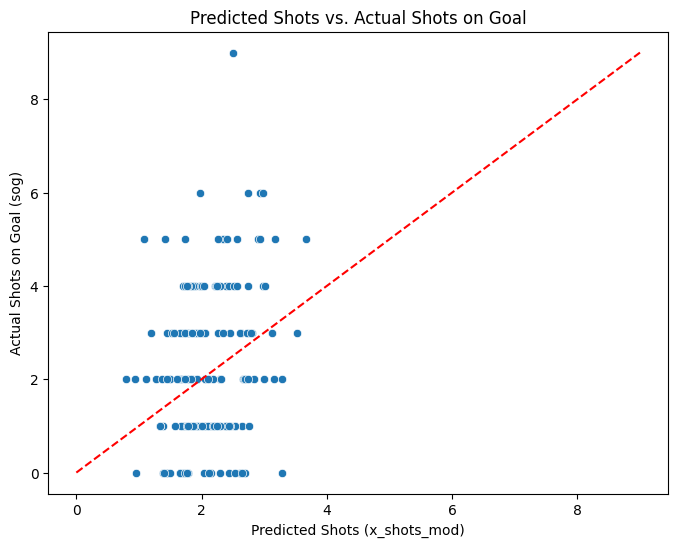

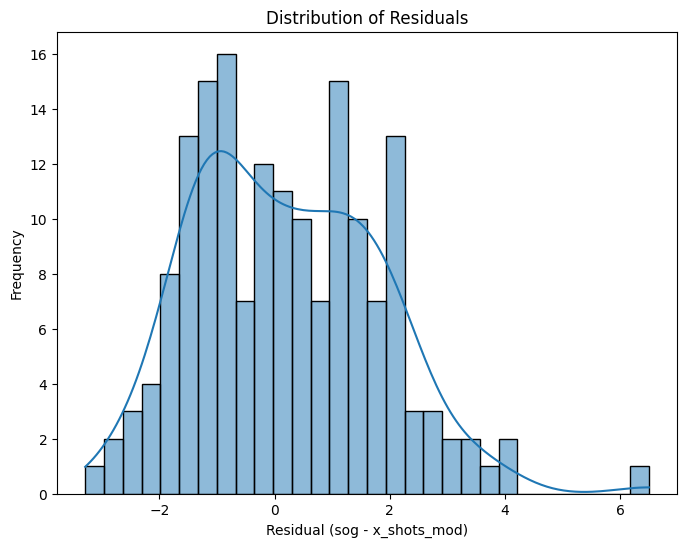

                 player  RMSE
0          Aaron Ekblad  0.34
1         Adam Fantilli  0.67
2          Adrian Kempe  1.54
3     Aleksander Barkov  1.03
4        Alex DeBrincat  1.57
..                  ...   ...
163    William Nylander  3.29
164      Wyatt Johnston  0.11
165  Yegor Sharangovich  0.86
166          Zach Hyman  0.55
167       Zach Werenski  1.29

[168 rows x 2 columns]


C:\Users\H-100\AppData\Local\Temp\ipykernel_2264\3061046609.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_rmse = data.groupby('player').apply(


In [47]:
from db_utils.prop_odds_db_utils import american_to_decimal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = combined_shots_df.dropna().copy()

# Ensure that the data is a deep copy to avoid SettingWithCopyWarning
data = combined_shots_df.dropna().copy()

# Convert American odds to Decimal odds using .loc
data.loc[:, 'over_decimal_odds'] = data['over_odds'].apply(american_to_decimal)
data.loc[:, 'under_decimal_odds'] = data['under_odds'].apply(american_to_decimal)

# If 'implied_over_prob' and 'implied_under_prob' are no longer needed, you can remove them
# data.loc[:, 'implied_over_prob'] = 1 / data['over_decimal_odds']
# data.loc[:, 'implied_under_prob'] = 1 / data['under_decimal_odds']

# Compare model predictions to actual shots on goal
# Calculate RMSE between model predictions and actual shots on goal
rmse = np.sqrt(mean_squared_error(data['sog'], data['x_shots_mod']))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Calculate MAE for additional insight
mae = mean_absolute_error(data['sog'], data['x_shots_mod'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R² Score to understand variance explained by the model
r2 = r2_score(data['sog'], data['x_shots_mod'])
print(f"R² Score: {r2:.4f}")

# Optional: Visualize the relationship between predicted and actual shots
plt.figure(figsize=(8, 6))
sns.scatterplot(x='x_shots_mod', y='sog', data=data)
plt.plot([data['sog'].min(), data['sog'].max()], [data['sog'].min(), data['sog'].max()], 'r--')  # Diagonal line
plt.title('Predicted Shots vs. Actual Shots on Goal')
plt.xlabel('Predicted Shots (x_shots_mod)')
plt.ylabel('Actual Shots on Goal (sog)')
plt.show()

# Optional: Residual Analysis
data['residuals'] = data['sog'] - data['x_shots_mod']

plt.figure(figsize=(8, 6))
sns.histplot(data['residuals'], bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (sog - x_shots_mod)')
plt.ylabel('Frequency')
plt.show()

# Optional: Per-Player RMSE
player_rmse = data.groupby('player').apply(
    lambda df: np.sqrt(mean_squared_error(df['sog'], df['x_shots_mod']))
).reset_index(name='RMSE')

print(player_rmse)